# Imports

In [80]:
import os
import warnings 

#
import numpy               as np
import pandas              as pd
import seaborn             as sns

from tabulate                import tabulate
from catboost                import CatBoostRegressor
from IPython.core.display    import HTML
from sklearn.model_selection import train_test_split
from matplotlib              import pyplot               as plt
from IPython.display         import Image

#model_selection divide o df em treino e test


warnings.filterwarnings( 'ignore' ) 
DEBUG = True
#https://www.kaggle.com/c/qualityeducation

### 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [35, 15]
    plt.rcParams['font.size'] = 50
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    sns.set()
jupyter_settings()

### Not using now

In [2]:
## Função Cross Validation
#def cross_validation( x_training, kfold, model_name, model, verbose=False):
#    
#    mae_list = []
#    mape_list = []
#    rmse_list = []
#
#
#    for k in reversed( range( 1, kfold+1 ) ):
#        if verbose:
#            print(f'\nKFold number: {k}') 
#        # Start and End date for validation
#        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
#        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 ) # coletando o ultimo periodo
#
#        # Filtering dataset
#        training = x_training[x_training['date'] < validation_start_date ] 
#        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ] 
#        
#        # training
#        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#        ytraining = training['sales']
#
#        # validation
#        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#        yvalidation = validation['sales']
#
#        # model
#        #lr = LinearRegression().fit( xtraining, ytraining) 
#        m = model.fit( xtraining, ytraining )
#        
#        # prediction
#        yhat = m.predict( xvalidation )
#        
#        # performance 
#        m_result = ml_error(model_name, np.exp(yvalidation), np.exp(yhat)) # numpy alterou exm1 para exp
#
#        # store performance of each kfold iteration
#        mae_list.append(m_result['MAE'])
#        mape_list.append(m_result['MAPE'])
#        rmse_list.append(m_result['RMSE'])
#
#    # Actual metric of model performance
#    return pd.DataFrame( {'Model Name': model_name,  
#                          'MAE CV': np.round(np.mean( mae_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mae_list ),2 ).astype(str),
#                          'MAPE CV': np.round(np.mean( mape_list),2 ).astype(str) + ' +/- ' + np.round(np.std( mape_list ),2 ).astype(str),
#                          'RMSE CV': np.round(np.mean( rmse_list),2 ).astype(str) + ' +/- ' + np.round(np.std( rmse_list ),2 ).astype(str)}, index=[0])
#                        
#
## Machine Learn Modelling
#def mean_percentage_error(y, yhat): #mpe
#    return np.mean( ( y - yhat ) / y )
#
#
#def mean_absolute_percentage_error(y, yhat): #mape
#    return np.mean( np.abs(( y - yhat ) / y ))
#
#def ml_error( model_name, y, yhat):
#    mae = mean_absolute_error(y, yhat)
#    mape = mean_absolute_percentage_error(y, yhat)
#    rmse = np.sqrt(mean_squared_error(y, yhat))
#
#    return pd.DataFrame({ 'Model Name': model_name,
#                          'MAE': mae,
#                          'MAPE': mape,
#                          'RSME': rmse }, index=[0] )
#
##Building cramer 'V'
## from scipy import stats
#def cramer_v( x, y ):
#    cm = pd.crosstab( x, y ).values 
#    n = cm.sum()
#    r, k = cm.shape
#    
#    chi2 = ss.chi2_contingency( cm )[0]
#    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
#    
#    kcorr = k - (k-1)**2/(n-1)
#    rcorr = r - (r-1)**2/(n-1)
#    
#    return np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1 ) ) )
#
#
# Function for format all over the graphics


## 0.2. Loading data

In [3]:
#df_train = pd.read_parquet('/home/bruno/repos/ml_olympiad_enem/data/external/train.parquet')
# New Data Frame
df_transf = pd.read_csv('../data/processed/df_train_clean.csv', low_memory=True)

# Business Problem:

O Brasil é considerado um país com dimensões continentais, é o quinto maior país do planeta. A grande extensão territorial do Brasil proporciona ao país uma enorme diversidade de paisagens, climas, topografia, fauna e flora.

Infelizmente hoje no Brasil se estima ter por volta de 11 milhões de analfabetos e 5,9 milhões de pessoas desempregadas. A educação permite a mobilidade socioeconômica ascendente e é a chave para escapar da pobreza. A educação ajuda a reduzir as desigualdades e alcançar a igualdade de gênero e é crucial para promover a tolerância e sociedades mais pacíficas. Desigualdades na educação são exacerbadas pelo COVID-19.

Esta análise visa criar um projeto a um dos 17 tópicos de Desenvolvimento Sustentável das Nações Unidas. **EDUCAÇÃO DE QUALIDADE**

O Exame Nacional do Ensino Médio (Enem) foi instituído no Brasil em 1998, com o objetivo de avaliar o desempenho escolar dos estudantes ao término da educação básica. Os dados e informações de edições passadas estão disponíveis no site: https://www.gov.br/inep/pt-br/areas-de-atuacao/avaliacao-e-exames-educacionais/enem

Nesse contexto, essa análise será focada nos dados do Enem disponibilizados no link abaixo. Neste projeto de predição iremos criar modelos para prever as notas dos alunos(as) nas provas: Ciências da Natureza, Ciências Humanas, Linguagens e Códigos, Matemática e Redação.

O Exame Nacional do Ensino Médio (Enem) é hoje a principal porta de entrada no ensino superior do Brasil. A prova viabiliza o acesso às instituições de educação públicas e privadas (sendo critério para conquista de bolsas de estudo e financiamento estudantil do governo federal). O resultado também é usado para o ingresso direto em universidades que utilizam a avaliação de forma integral ou como complemento aos seus vestibulares próprios para entrada em seus cursos de graduação.

# 1.0. Step 01 - Data Description

In [44]:
df1 = df_transf.copy()

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405748 entries, 0 to 2405747
Data columns (total 43 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   NU_INSCRICAO             object 
 2   CO_MUNICIPIO_RESIDENCIA  int64  
 3   NO_MUNICIPIO_RESIDENCIA  object 
 4   CO_UF_RESIDENCIA         int64  
 5   SG_UF_RESIDENCIA         object 
 6   NU_IDADE                 int64  
 7   TP_SEXO                  object 
 8   TP_ESTADO_CIVIL          int64  
 9   TP_COR_RACA              int64  
 10  TP_NACIONALIDADE         int64  
 11  NU_NOTA_CN               float64
 12  NU_NOTA_CH               float64
 13  NU_NOTA_LC               float64
 14  NU_NOTA_MT               float64
 15  TP_LINGUA                int64  
 16  TP_STATUS_REDACAO        int64  
 17  NU_NOTA_REDACAO          float64
 18  Q001                     object 
 19  Q002                     object 
 20  Q003                     object 
 21  Q004    

In [13]:
df1.head(3)

,Unnamed: 0,NU_INSCRICAO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,1100023,Ariquemes,11,RO,31,F,0,1,1,426.50000,487.39999,530.90002,415.29999,1,1,680.00000,B,A,A,A,2,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,3106200,Belo Horizonte,31,MG,23,F,1,3,1,463.00000,452.29999,456.60001,407.20001,0,1,520.00000,B,C,D,B,2,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,3139409,Manhuaçu,31,MG,17,M,0,3,1,381.70001,474.39999,530.59998,622.79999,0,1,600.00000,E,B,C,D,3,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B


### 1.1. Data Dimensions

In [14]:
print( f'Number of Rows: {df1.shape[0]}' )
print( f'Number of Columns: {df1.shape[1]}' ) 

Number of Rows: 2405748
Number of Columns: 43


### 1.4. Data Types

In [15]:
df1.dtypes

Unnamed: 0                   int64
NU_INSCRICAO                object
CO_MUNICIPIO_RESIDENCIA      int64
NO_MUNICIPIO_RESIDENCIA     object
CO_UF_RESIDENCIA             int64
SG_UF_RESIDENCIA            object
NU_IDADE                     int64
TP_SEXO                     object
TP_ESTADO_CIVIL              int64
TP_COR_RACA                  int64
TP_NACIONALIDADE             int64
NU_NOTA_CN                 float64
NU_NOTA_CH                 float64
NU_NOTA_LC                 float64
NU_NOTA_MT                 float64
TP_LINGUA                    int64
TP_STATUS_REDACAO            int64
NU_NOTA_REDACAO            float64
Q001                        object
Q002                        object
Q003                        object
Q004                        object
Q005                         int64
Q006                        object
Q007                        object
Q008                        object
Q009                        object
Q010                        object
Q011                

### 1.2. Drop. Columns

In [5]:
col = ['Unnamed: 0']
df1 = df1.drop(col, axis=1)

In [6]:
df1.isna().sum()

NU_INSCRICAO               0
CO_MUNICIPIO_RESIDENCIA    0
NO_MUNICIPIO_RESIDENCIA    0
CO_UF_RESIDENCIA           0
SG_UF_RESIDENCIA           0
NU_IDADE                   0
TP_SEXO                    0
TP_ESTADO_CIVIL            0
TP_COR_RACA                0
TP_NACIONALIDADE           0
NU_NOTA_CN                 0
NU_NOTA_CH                 0
NU_NOTA_LC                 0
NU_NOTA_MT                 0
TP_LINGUA                  0
TP_STATUS_REDACAO          0
NU_NOTA_REDACAO            0
Q001                       0
Q002                       0
Q003                       0
Q004                       0
Q005                       0
Q006                       0
Q007                       0
Q008                       0
Q009                       0
Q010                       0
Q011                       0
Q012                       0
Q013                       0
Q014                       0
Q015                       0
Q016                       0
Q017                       0
Q018          

### 1.3 Descriptive Statistical

In [45]:
# Analysis of metrics
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

### 1.3.1 Numerical Attributes

In [31]:
# Central tendency - mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

# Rename columns
m.columns = ( ['attributes', 'min', 'max', 'mean', 'median', 'range', 'std', 'skew', 'kurtosis',] )
m 

,attributes,min,max,mean,median,range,std,skew,kurtosis
0,CO_MUNICIPIO_RESIDENCIA,1100015.00000,5300108.00000,4200093.00000,3078109.10541,3118601.00000,988524.42649,0.29978,-0.11792
1,CO_UF_RESIDENCIA,11.00000,53.00000,42.00000,30.63084,31.00000,9.85440,0.32774,-0.08171
2,NU_IDADE,10.00000,92.00000,82.00000,21.17063,19.00000,6.95272,2.64060,8.13677
3,TP_ESTADO_CIVIL,0.00000,4.00000,4.00000,1.05630,1.00000,0.39672,2.20715,11.84219
4,TP_COR_RACA,0.00000,5.00000,5.00000,2.11011,2.00000,1.01989,-0.07227,-1.20594
5,TP_NACIONALIDADE,0.00000,4.00000,4.00000,1.03074,1.00000,0.21276,7.83924,83.23310
6,NU_NOTA_CN,0.00000,860.90002,860.90002,477.87349,470.29999,76.03709,0.36124,-0.25421
7,NU_NOTA_CH,0.00000,835.09998,835.09998,509.87041,513.29999,81.01884,-0.18686,0.40935
8,NU_NOTA_LC,0.00000,801.70001,801.70001,522.39118,527.79999,62.75968,-0.59733,1.40916
9,NU_NOTA_MT,0.00000,985.50000,985.50000,523.16427,501.10001,109.03926,0.68931,-0.05844


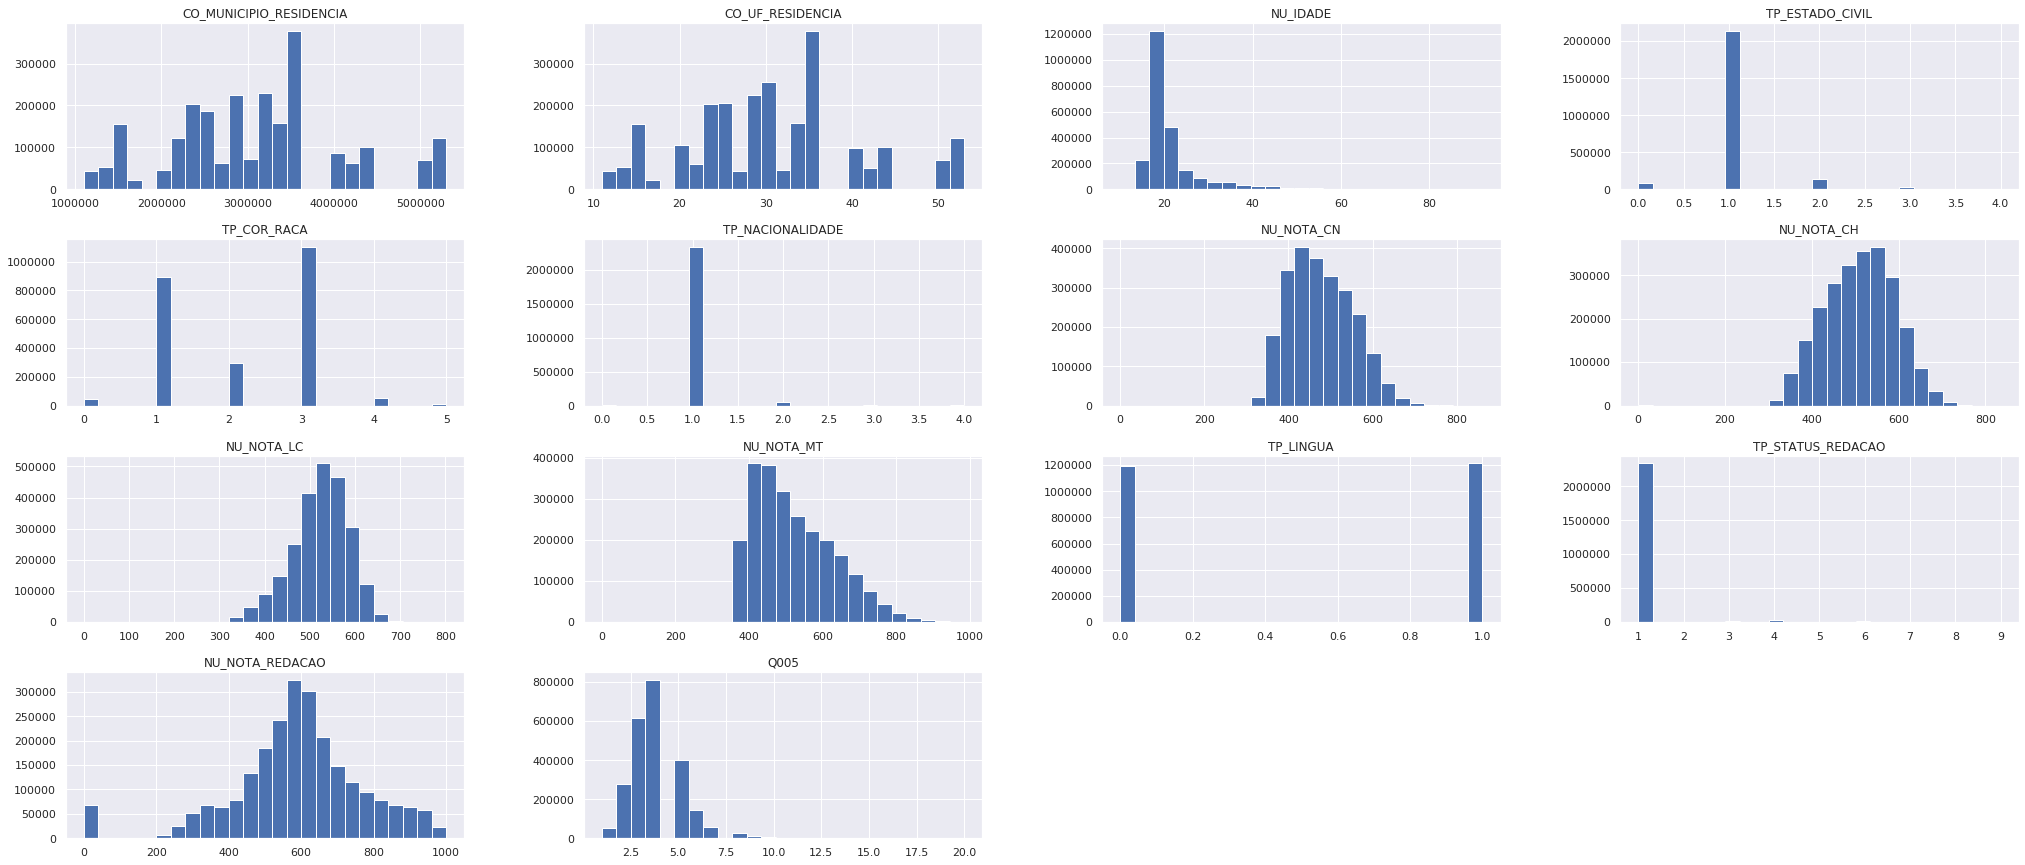

In [32]:
num_attributes.hist(bins=25);

### 1.7.2 Categorical Attributes

In [33]:
cat_attributes.dtypes

NU_INSCRICAO               object
NO_MUNICIPIO_RESIDENCIA    object
SG_UF_RESIDENCIA           object
TP_SEXO                    object
Q001                       object
Q002                       object
Q003                       object
Q004                       object
Q006                       object
Q007                       object
Q008                       object
Q009                       object
Q010                       object
Q011                       object
Q012                       object
Q013                       object
Q014                       object
Q015                       object
Q016                       object
Q017                       object
Q018                       object
Q019                       object
Q020                       object
Q021                       object
Q022                       object
Q023                       object
Q024                       object
Q025                       object
dtype: object

In [36]:
# Checking the unique values of each category
cat_attributes.apply(lambda x: x.unique())

NU_INSCRICAO               [d7e73c5f-2db8-4089-9bee-d3a0e045f87f, 668bf6e...
NO_MUNICIPIO_RESIDENCIA    [Ariquemes, Belo Horizonte, Manhuaçu, Guarabir...
SG_UF_RESIDENCIA           [RO, MG, PB, CE, PI, MA, RN, BA, AL, SP, SC, M...
TP_SEXO                                                               [F, M]
Q001                                                [B, E, C, G, D, F, H, A]
Q002                                                [A, C, B, E, D, F, H, G]
Q003                                                      [A, D, C, B, E, F]
Q004                                                      [A, B, D, F, C, E]
Q006                       [E, F, B, L, G, J, C, D, H, Q, M, A, P, O, N, ...
Q007                                                            [A, D, B, C]
Q008                                                         [B, E, C, D, A]
Q009                                                         [C, D, E, B, A]
Q010                                                         [C, A, B, D, E]

# 2.0. EDA

In [8]:
df2 = df1.copy()

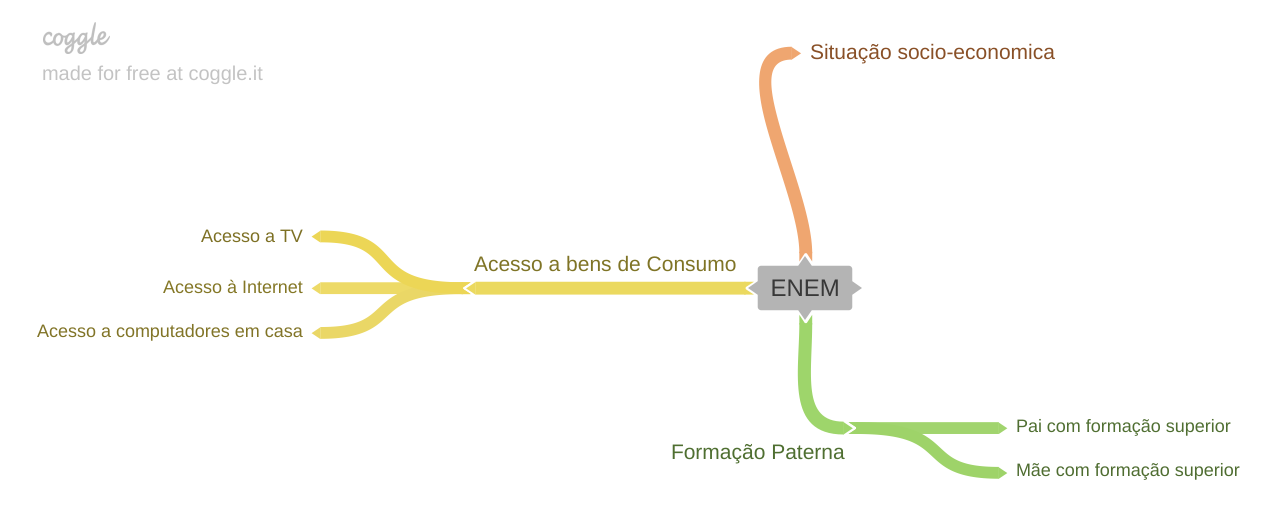

In [40]:
Image('ENEM.png')

### H1. A condição socio-economica pouco interfere no resultados das notas!
## **Falso**: Quanto melhor a condição financeira familiar do estudante maiores serão suas notas!

In [41]:
aux1 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006']].groupby('Q006').mean()
aux1

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q006,,,,,
A,501.94829,440.30224,468.16116,485.93577,468.32153
B,523.26791,445.33722,475.25963,494.00988,475.93106
C,552.09058,461.93511,494.95846,511.95563,496.62070
D,576.30863,477.85352,511.95851,525.73031,521.92822
E,590.26575,483.48169,518.34115,530.82511,529.64909
F,612.05862,497.19214,531.00732,540.24772,552.51033
G,627.34218,503.21513,537.27423,544.96136,561.05974
H,650.95231,517.85823,549.97540,553.94742,583.09254
I,664.69249,524.25680,556.09794,558.23602,594.05366


* A	Nenhuma renda.

* B	Até R$ 998,00.

* C	De R$ 998,01 até R$ 1.497,00.

* D	De R$ 1.497,01 até R$ 1.996,00.

* E	De R$ 1.996,01 até R$ 2.495,00.

* F	De R$ 2.495,01 até R$ 2.994,00.

* G	De R$ 2.994,01 até R$ 3.992,00.

* H	De R$ 3.992,01 até R$ 4.990,00.

* I	De R$ 4.990,01 até R$ 5.988,00.

* J	De R$ 5.988,01 até R$ 6.986,00.

* K	De R$ 6.986,01 até R$ 7.984,00.

* L	De R$ 7.984,01 até R$ 8.982,00.

* M	De R$ 8.982,01 até R$ 9.980,00.

* N	De R$ 9.980,01 até R$ 11.976,00.

* O	De R$ 11.976,01 até R$ 14.970,00.

* P	De R$ 14.970,01 até R$ 19.960,00.

* Q	Mais de R$ 19.960,00.

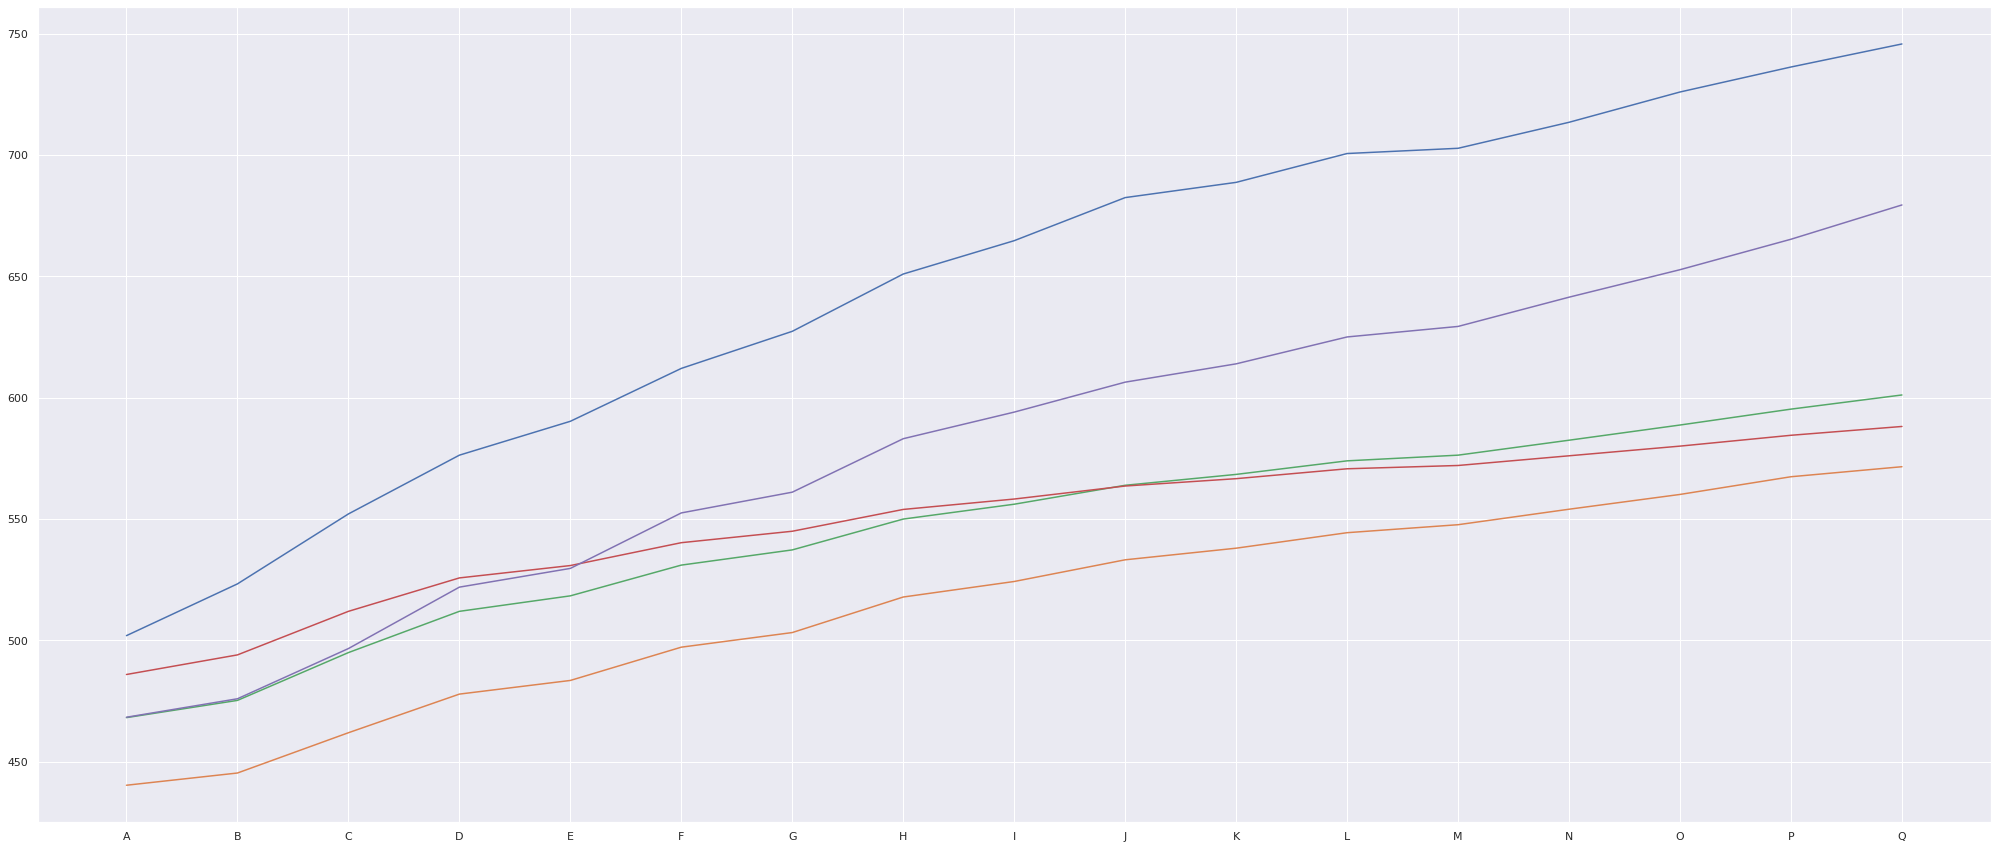

In [16]:
a = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006']].groupby('Q006').mean()
plt.plot(a);

### H2. Alunos com acesso a TV em casa obtem melhores resultados?
## **Verdadeiro!**

In [17]:
aux2 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q019']].groupby('Q019').mean()
aux2

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q019,,,,,
A,542.73953,461.78969,492.73894,506.74913,497.28139
B,558.84949,465.91893,497.66249,512.79437,504.34885
C,619.32269,500.14921,533.65628,541.80630,557.46838
D,658.16112,521.37825,553.34756,556.47273,592.34525
E,690.74429,539.47419,569.17217,567.91909,624.38834


* A	Não.

* B	Sim, uma.

* C	Sim, duas.

* D	Sim, três.

* E	Sim, quatro ou mais.

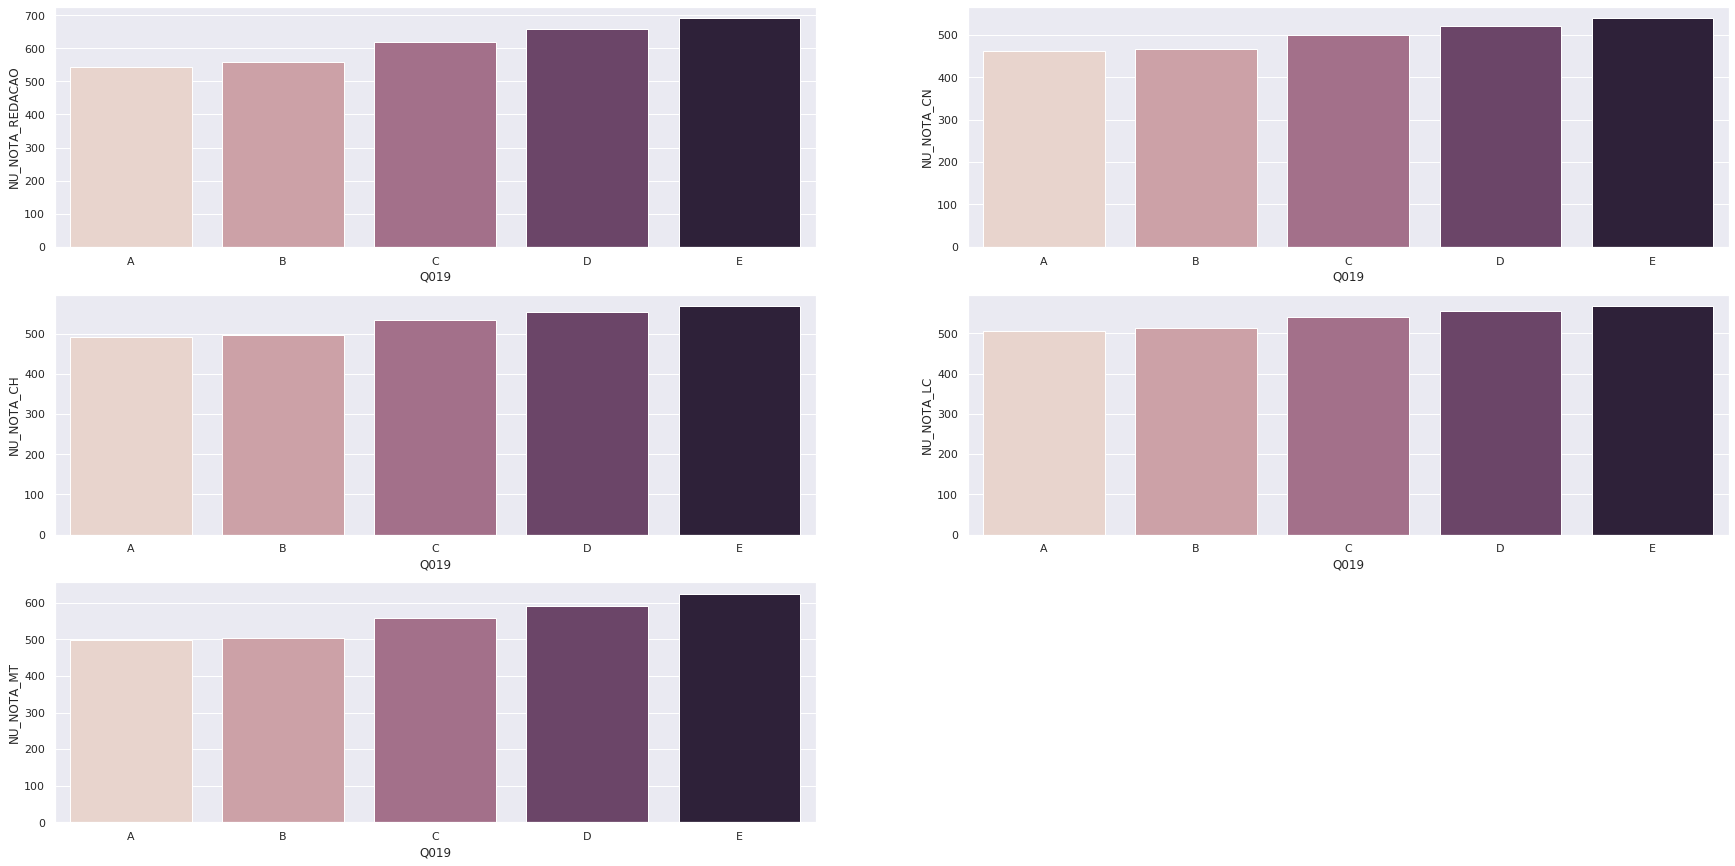

In [68]:
#plt.plot(aux2);
plt.subplot(3, 2, 1)
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df2[['NU_NOTA_REDACAO', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_REDACAO', data=aux1, palette="ch:.05");

plt.subplot(3, 2, 2)
# O aux1 já responde essas questão. Daqui em diante vou validar se "extra", "basic" e "extend" 
#faz jús ao tamanho da loja e não apenas um breve comportamento dos clientes.
aux2 = df2[['NU_NOTA_CN', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_CN', data=aux2, palette="ch:.05");

plt.subplot(3, 2, 3)
aux3 = df2[['NU_NOTA_CH', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_CH', data=aux3, palette="ch:.05");

plt.subplot(3, 2, 4)
aux4 = df2[['NU_NOTA_LC', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_LC', data=aux4, palette="ch:.05");

plt.subplot(3, 2, 5)
aux5 = df2[['NU_NOTA_MT', 'Q019']].groupby('Q019').mean().reset_index()
sns.barplot(x='Q019', y='NU_NOTA_MT', data=aux5, palette="ch:.05");

### H3. Alunos com acesso a internet em casa obtem melhores resultados?
## **Verdadeiro!**
* B = sim à acesso a internet
* A = Não á acesso a internet

In [39]:
# Notas relacionadas ao acesso ou não a internet em casa
b = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q025']].groupby('Q025').mean()
b

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q025,,,,,
A,515.44872,445.43019,474.71460,492.26096,474.71820
B,596.94919,486.57529,519.29975,530.47258,536.15826


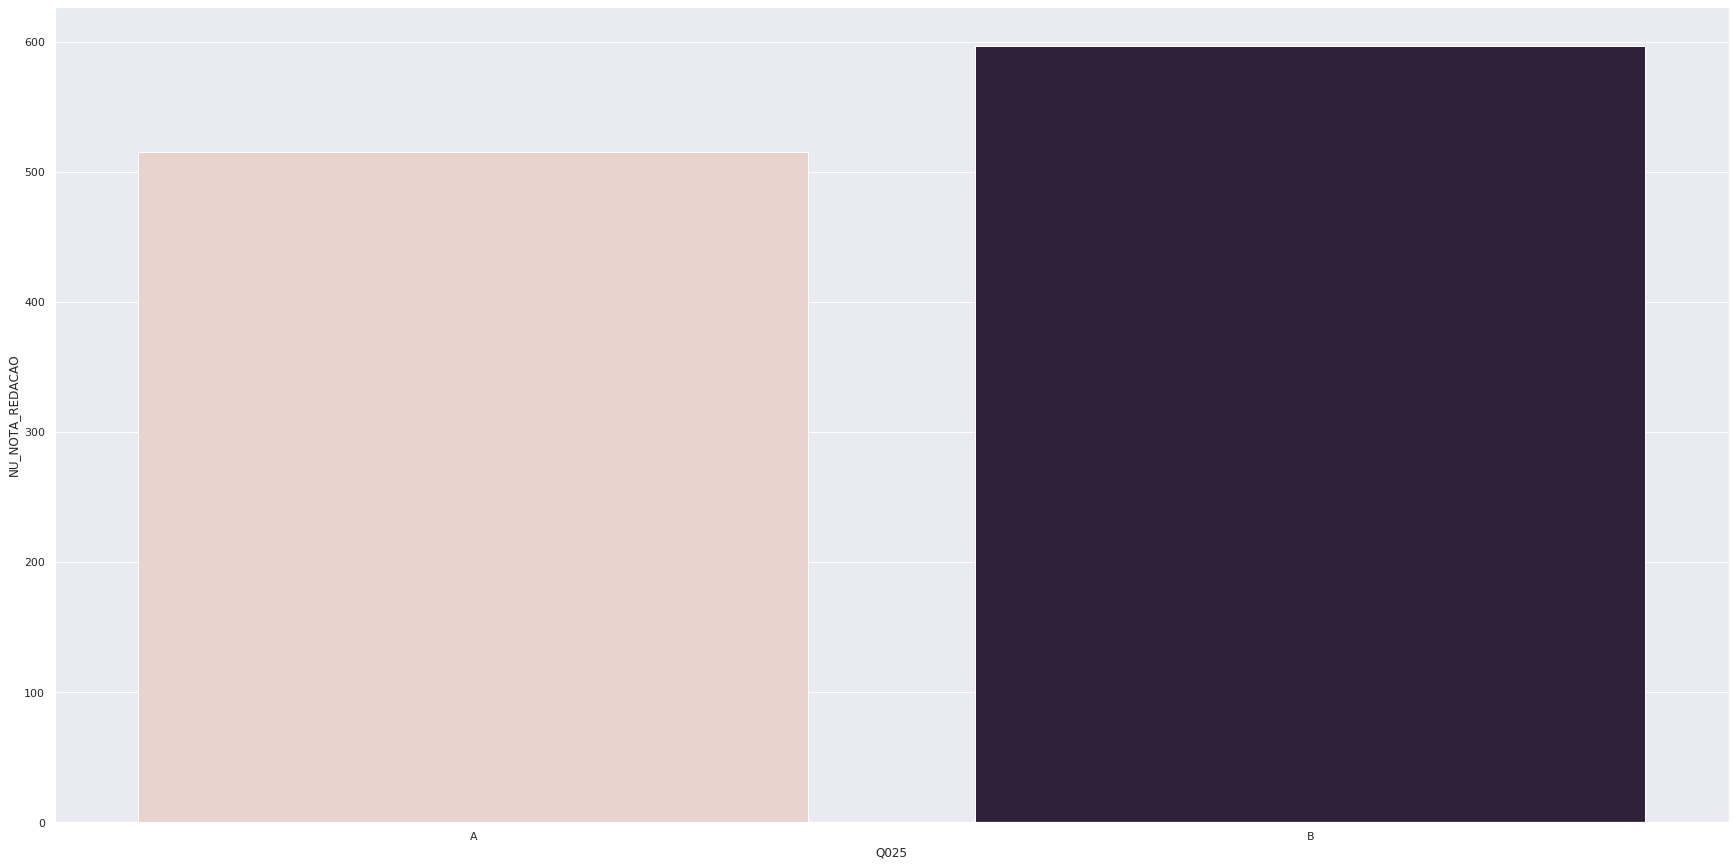

In [73]:
#plt.subplot(3, 2, 1)
# Checking product assortment size and sales by each store type. Let's look at which variables make sense to group and return this value
# showing the sum of sales per store categorized by display type (number of products)
aux1 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q025']].groupby('Q025').mean().reset_index()
sns.barplot(x='Q025', y='NU_NOTA_REDACAO', data=aux1, palette="ch:.05");


### H4. Alunos com acesso a computadores em casa obtem melhores resultados?
## **Verdadeiro!**

* A Não.

* B Sim, um.

* C Sim, dois.

* D Sim, três.

* E Sim, quatro ou mais.

In [34]:
# Notas relacionadas ao acesso ou não a internet em casa
aux3 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q024']].groupby('Q024').mean()
aux3

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q024,,,,,
A,529.77876,450.04375,480.65617,499.30938,483.37254
B,602.01657,489.16719,522.65246,533.07010,538.00111
C,669.82030,531.01457,563.27841,563.01622,601.88578
D,701.04299,551.37437,581.80692,576.07783,635.90393
E,715.85287,564.01981,592.94121,583.78828,661.02960


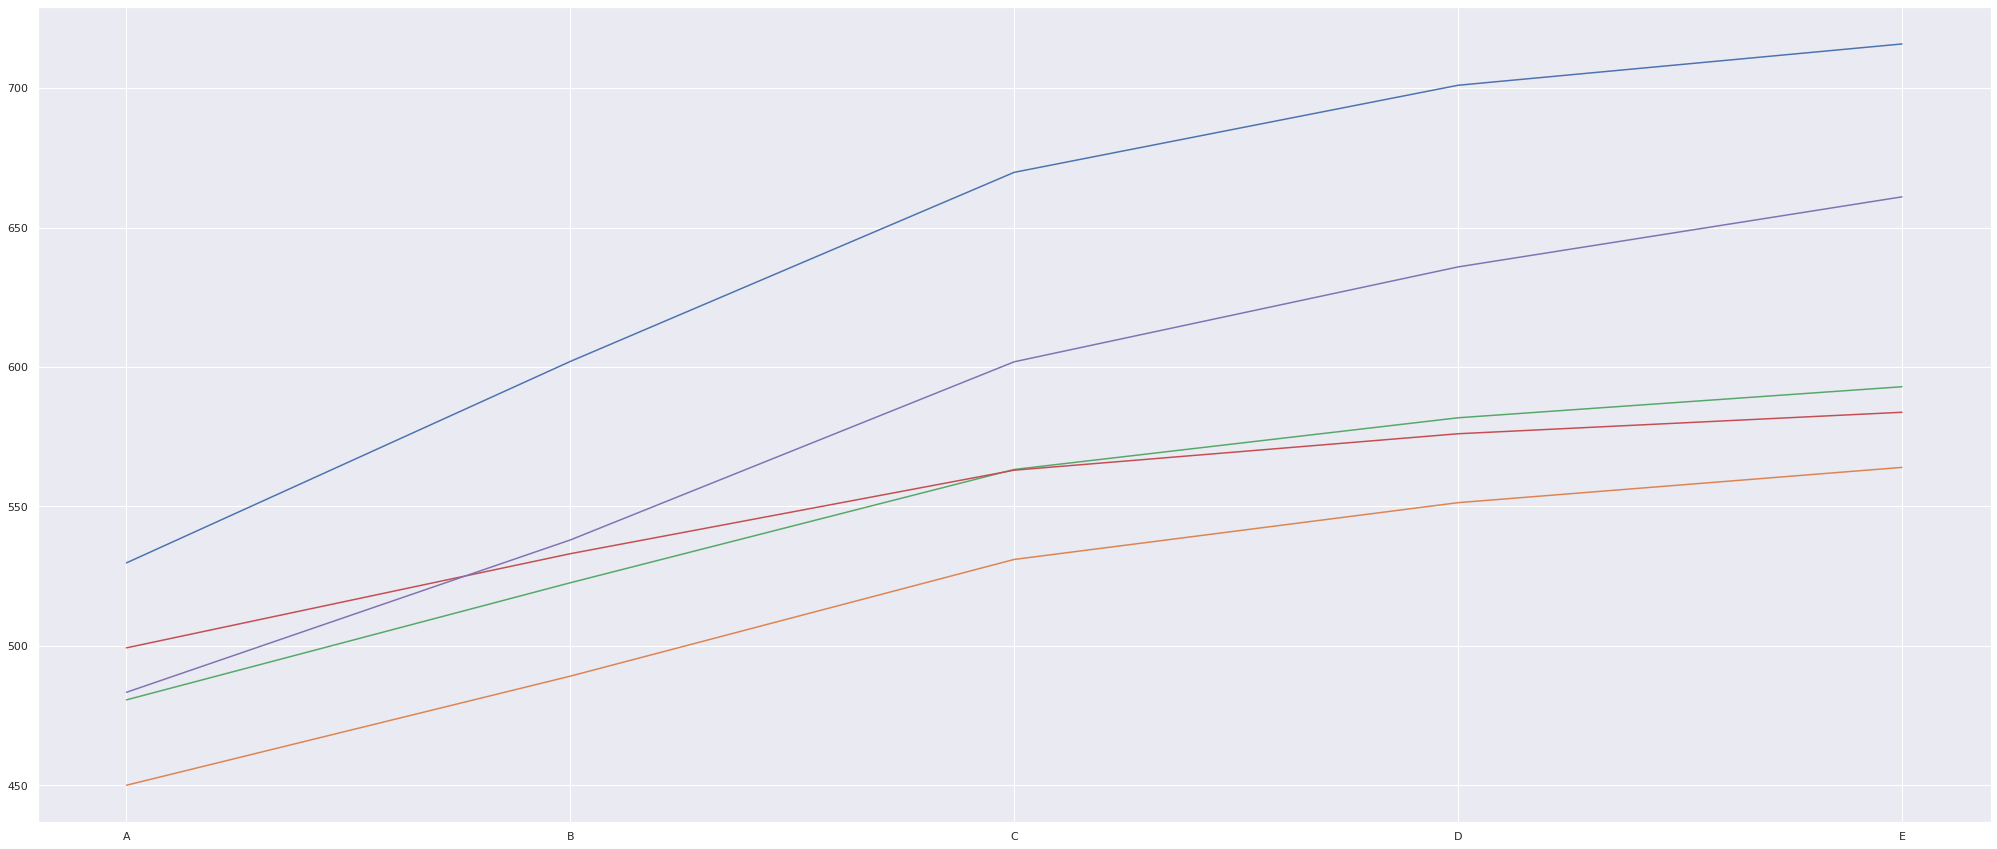

In [36]:
plt.plot(aux3);

### H5. Alunos cujo os pais tem formação superior, tem as melhores notas!
## **Verdadeiro!**

* A	Nunca estudou.

* B	Não completou a 4ª série/5º ano do Ensino Fundamental.

* C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.

* D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.

* E	Completou o Ensino Médio, mas não completou a Faculdade.

* F	Completou a Faculdade, mas não completou a Pós-graduação.

* G	Completou a Pós-graduação.

* H	Não sei.


In [37]:
# Notas relacionadas ao acesso ou não a internet em casa
aux4 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q001']].groupby('Q001').mean()
aux4

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q001,,,,,
A,495.76855,442.38214,471.99219,486.74540,466.23319
B,532.62101,454.43000,486.17798,502.14248,486.54550
C,558.09236,465.19686,497.68100,513.10752,505.23820
D,574.69698,471.90524,504.55876,519.72348,515.63902
E,604.85021,488.25642,521.22789,533.26858,538.98070
F,673.57643,528.81595,559.46286,560.84113,600.06957
G,700.19290,543.74764,572.61982,569.34630,624.23914
H,537.00840,459.96594,492.40487,509.21908,495.55026


### H6. Alunos cujo as mães tem formação superior, tem as melhores notas!
## **Verdadeiro!**

* A	Nunca estudou.

* B	Não completou a 4ª série/5º ano do Ensino Fundamental.

* C	Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.

* D	Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.

* E	Completou o Ensino Médio, mas não completou a Faculdade.

* F	Completou a Faculdade, mas não completou a Pós-graduação.

* G	Completou a Pós-graduação.

* H	Não sei.


In [38]:
# Notas relacionadas ao acesso ou não a internet em casa
aux5 = df2[['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q002']].groupby('Q002').mean()
aux5

,NU_NOTA_REDACAO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT
Q002,,,,,
A,482.22510,440.87367,470.83069,484.04215,460.08365
B,522.30264,451.52821,483.69718,499.10212,480.26270
C,543.75971,459.67351,492.33407,508.19737,496.08270
D,559.02756,464.78703,497.60777,514.14613,504.91339
E,590.96451,480.82045,513.75431,527.58138,528.24786
F,655.50363,517.36626,547.90661,552.33342,583.39881
G,676.16517,527.05217,556.79970,558.13227,598.75662
H,504.78207,450.72796,479.11794,494.98531,484.34807


In [96]:
df3.columns

Index(['NU_INSCRICAO', 'CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA',
       'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q003', 'Q004',
       'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013',
       'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022',
       'Q023', 'Q024', 'Q025'],
      dtype='object')

# 30. EDA

In [41]:
df3 = df2.copy()

### 3.1. Univariate Analysis

#### 3.1.0. Numerical Variable

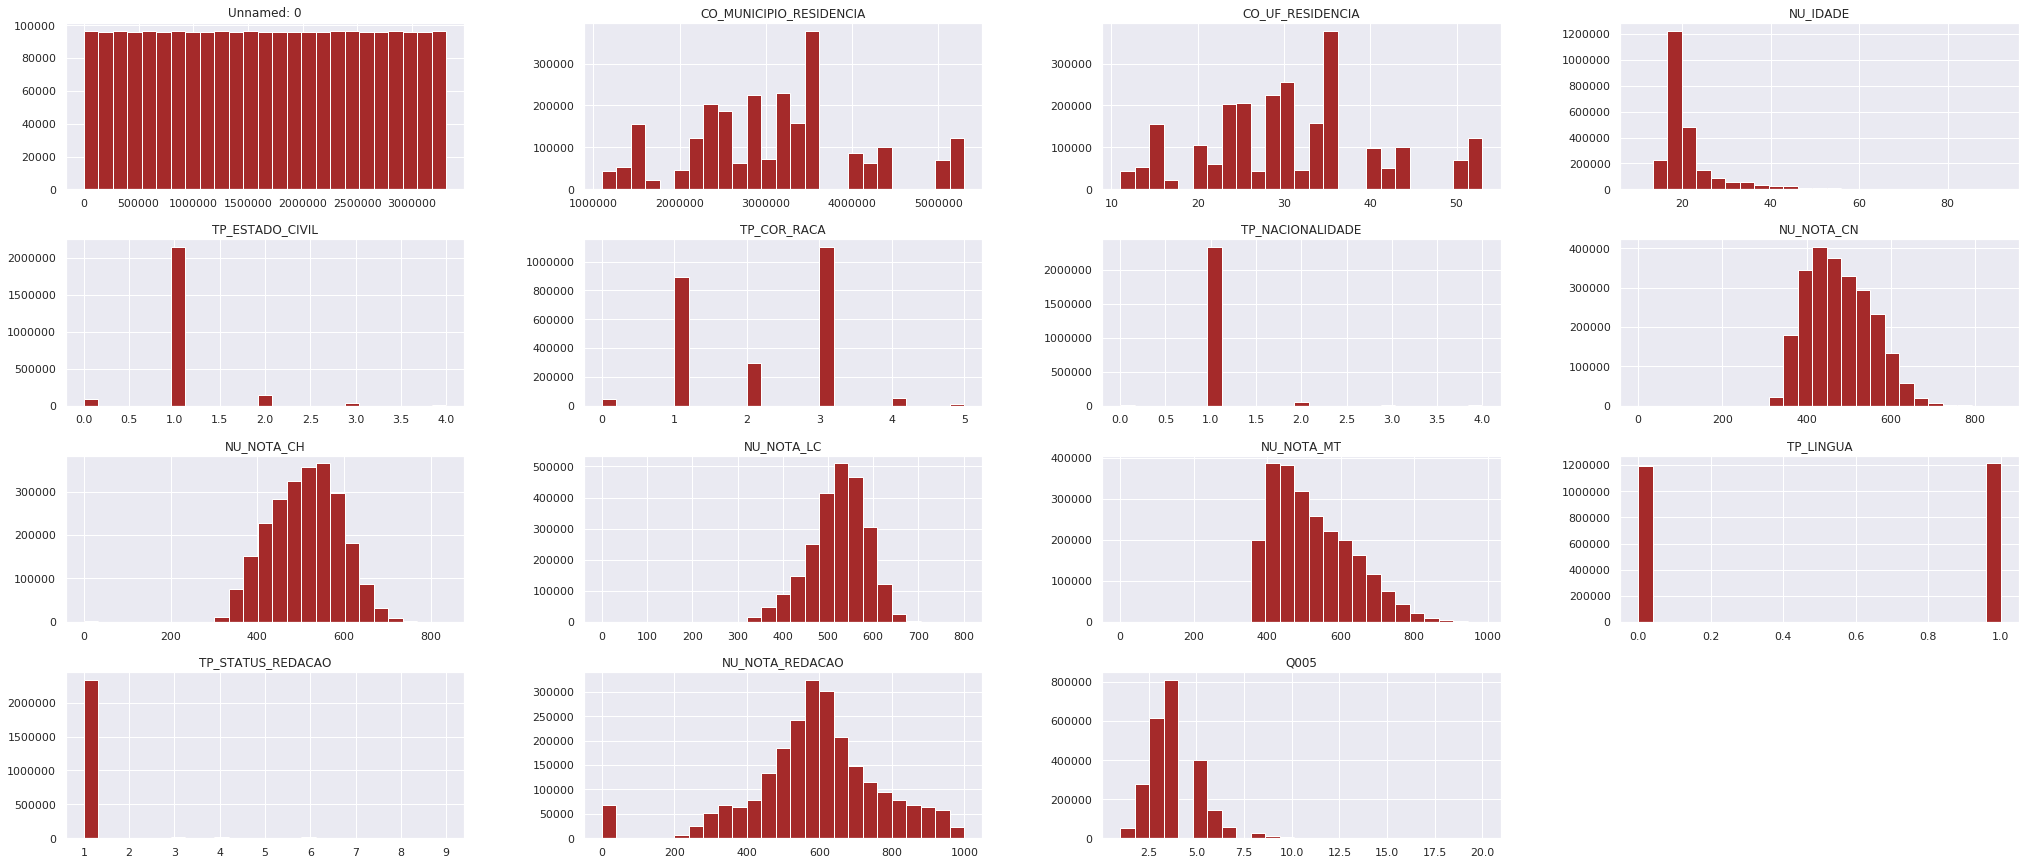

In [46]:
num_attributes.hist(bins=25, color='brown');
plt.rcParams['figure.figsize'] = [30, 15]

#### 3.2.0. Categorical Varible

In [75]:
cat_attributes.head()

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,SG_UF_RESIDENCIA,TP_SEXO,Q001,Q002,Q003,Q004,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,Ariquemes,RO,F,B,A,A,A,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,Belo Horizonte,MG,F,B,C,D,B,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B
2,951e80d6-ac9b-4ff2-8130-fcbc8ac78b16,Manhuaçu,MG,M,E,B,C,D,F,A,B,C,B,A,B,A,B,A,B,A,B,C,B,B,D,A,B,B
3,baf409f9-ddc6-4e82-9a4b-b64b579cd105,Guarabira,PB,M,C,E,B,B,B,A,B,D,A,A,B,B,A,A,B,A,A,B,A,A,E,A,A,B
4,9fd415ac-3421-44ce-810e-599545c3c025,Fortaleza,CE,M,G,E,E,B,L,D,E,E,B,A,B,A,B,A,B,A,A,E,B,B,C,B,B,B


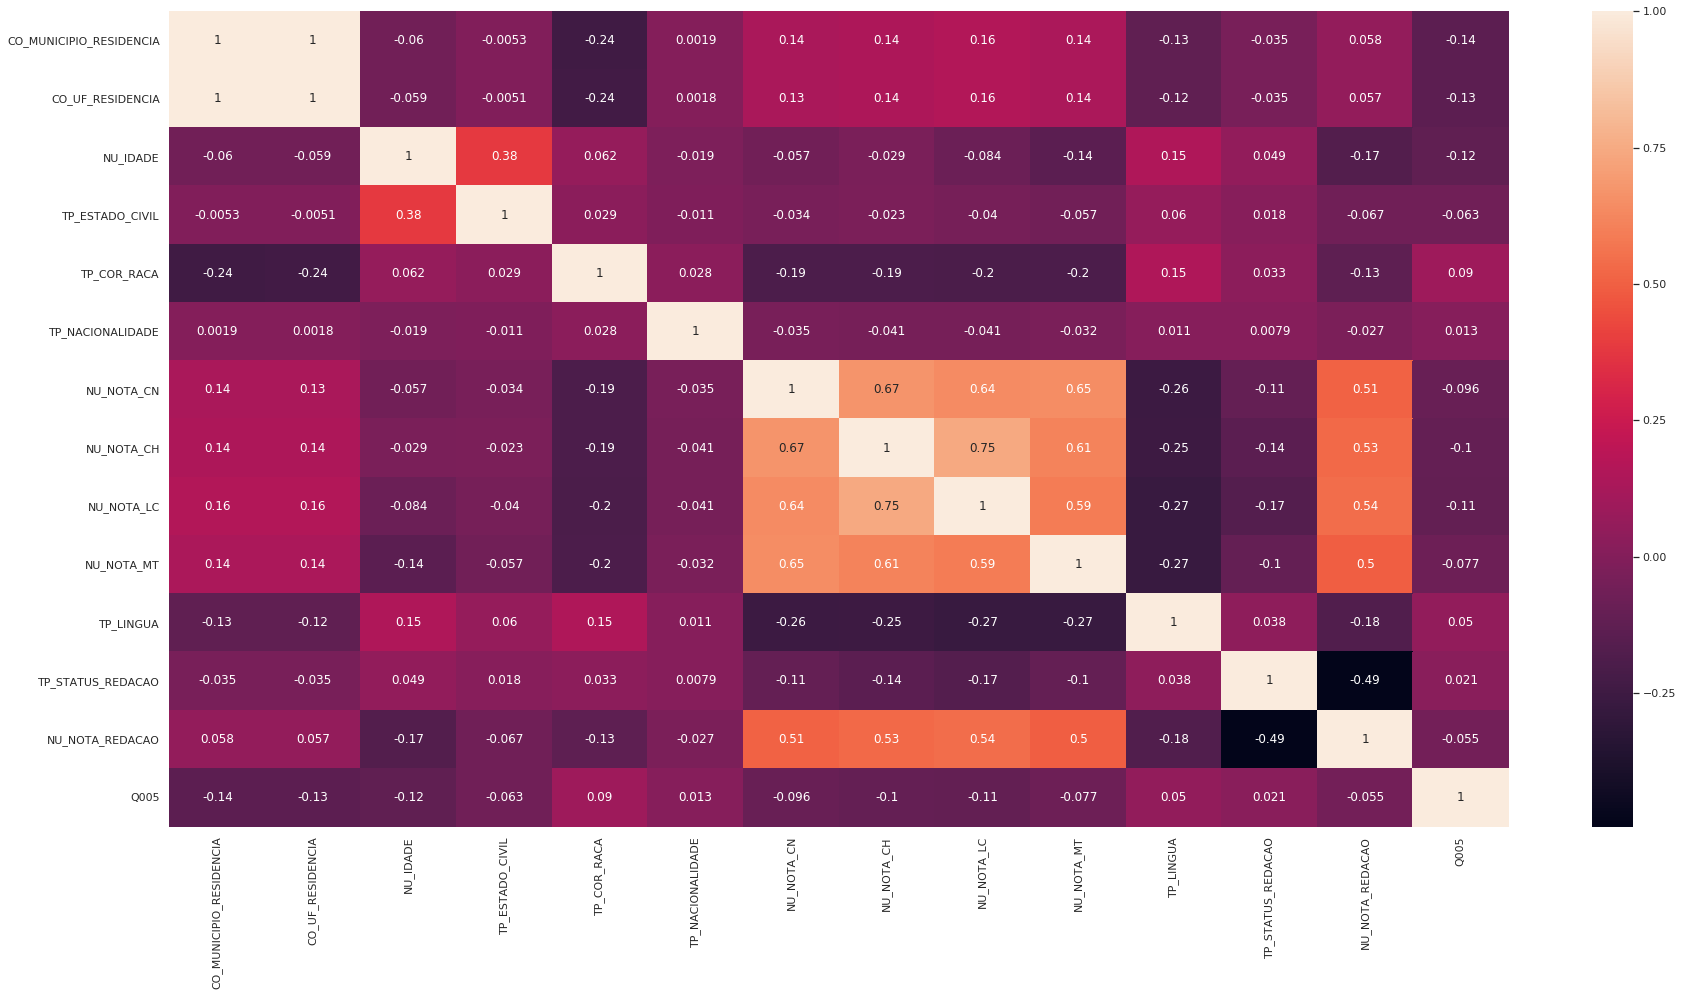

In [77]:

sns.heatmap( df3.corr( method='pearson'), annot=True);

In [81]:
tab = [['Hyposthesis', 'Conclusion', 'Relevance'],
       ['H1', 'Verdadeiro', 'Alto'],
       ['H2', 'Verdadeiro', 'Alto'],
       ['H3', 'Verdadeiro', 'Alto'],
       ['H4', 'Verdadeiro', 'Alto'],
       ['H5', 'Verdadeiro', 'Alto'],
       ['H6', 'Verdadeiro', 'Alto'],
      ]
print( tabulate( tab, headers='firstrow'))

Hyposthesis    Conclusion    Relevance
-------------  ------------  -----------
H1             Falso         Alto
H2             Verdadeiro    Alto
H3             Verdadeiro    Alto
H4             Verdadeiro    Alto
H5             Verdadeiro    Alto
H6             Verdadeiro    Alto


In [45]:
## Setting up the table
## 1st Only categorical data analysis method V-Krumer
#a = df4.select_dtypes( include='object' )
#
#a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
#a2 = cramer_v( a['state_holiday'], a['store_type'] )
#a3 = cramer_v( a['state_holiday'], a['assortment'] )
#
#a4 = cramer_v( a['store_type'], a['state_holiday'] )
#a5 = cramer_v( a['store_type'], a['store_type'] )
#a6 = cramer_v( a['store_type'], a['assortment'] )
#
#a7 = cramer_v( a['assortment'], a['state_holiday'] )
#a8 = cramer_v( a['assortment'], a['store_type'] )
#a9 = cramer_v( a['assortment'], a['assortment'] )
#
## 3º Final dataset
#d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
#                   'store_type': [a4, a5, a6],
#                   'assortment': [a7, a8, a9]} )
#
d = cat_attributes
#d = d.set_index( d.columns )
#print(d)


sns.heatmap( d, annot=True );
'''Notice that there is a "strong" correlation only between the "store_type" and the "assortment".'''

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# 5.0. Step 05 -  DATA PREPARATION

### Read df_eda DataFrame

In [16]:
df5 = df3.copy()

In [14]:
#df5['date'] = pd.to_datetime( df5['date'] )
#df5['competition_open_since_month'] = df5['competition_open_since_month'].astype( int )
#df5['competition_open_since_year'] = df5['competition_open_since_year'].astype( int )
#
#df5['promo2_since_week'] = df5['promo2_since_week'].astype( int )
#df5['promo2_since_year'] = df5['promo2_since_year'].astype( int )
#df5.dtypes

### 5.1. Normalization

#### It is not necessary for us to put in this dataset

### 5.2. Rescaling

In [17]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
a = df5.select_dtypes( include=[ 'int8', 'int32', 'float32' ] )


In [18]:
a.head()

,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_TEMPO_ADICIONAL,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,CO_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q005
0,31.0,0,1,1,1,10,1,1.0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100023,11,1,1,1,1,426.500000,487.399994,530.900024,415.299988,1,1.0,680.0,2
1,23.0,1,3,1,1,3,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3106200,31,1,1,1,1,463.000000,452.299988,456.600006,407.200012,0,1.0,520.0,2
2,17.0,0,3,1,2,0,2,1.0,2.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3139409,31,1,1,1,1,381.700012,474.399994,530.599976,622.799988,0,1.0,600.0,3
3,16.0,1,1,1,3,0,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2506301,25,1,1,1,1,426.700012,343.899994,444.200012,507.000000,1,1.0,660.0,4
4,19.0,1,1,1,1,1,1,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2304400,23,1,1,1,1,623.700012,609.099976,637.099976,805.299988,0,1.0,840.0,2


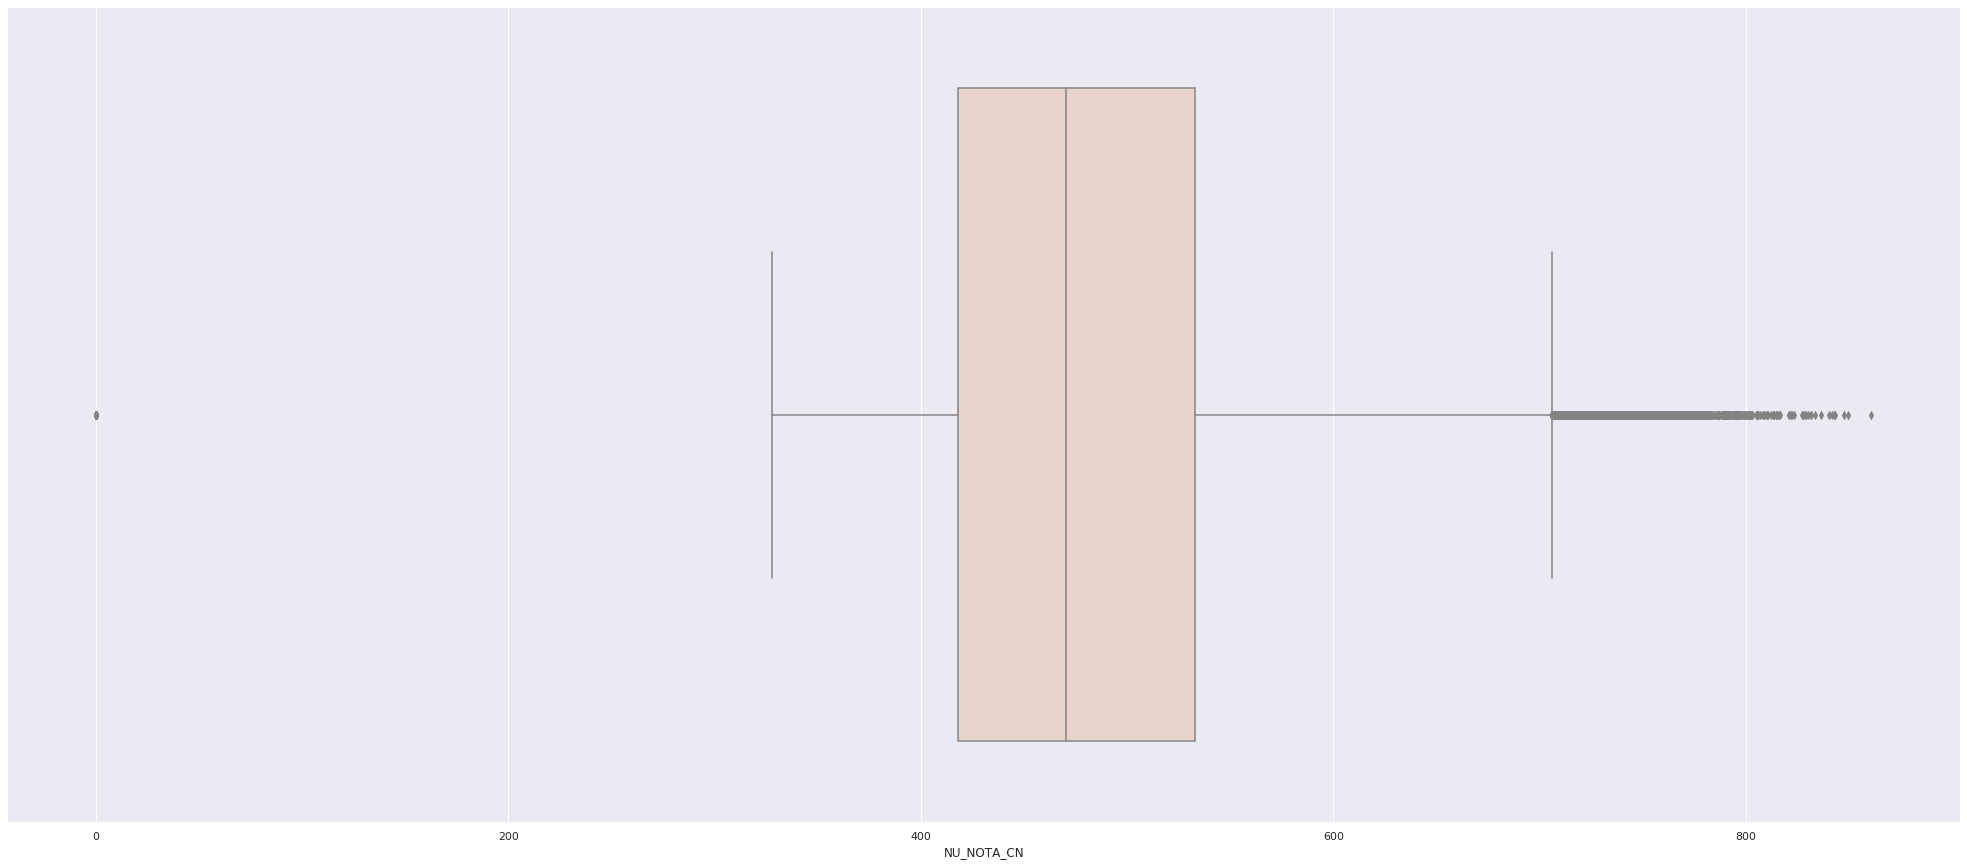

In [19]:
#sns.boxplot( df5[['competition_distance', 'competition_time_month']] )
sns.boxplot( df5['NU_NOTA_CN'], palette="ch:.05" );
# using this comand, olny looked if exist or no outlayers
# usar os interquartis ou o RobustScaling nos livra das dependencias das outlayers

In [61]:
#from sklearn.preprocessing import RobustScaler
# Preparing the data
rs = RobustScaler() 
mms = MinMaxScaler()

# competition_distance
df5['NU_NOTA_CN'] = rs.fit_transform( df5[['NU_NOTA_CN']].values )
#pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['NU_NOTA_CH'] = rs.fit_transform( df5[['NU_NOTA_CH']].values )
#pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week 
df5['NU_NOTA_LC'] = mms.fit_transform( df5[['NU_NOTA_LC']].values )
#pickle.dump(mms, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['NU_NOTA_MT'] = mms.fit_transform( df5[['NU_NOTA_MT']].values )
#pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))


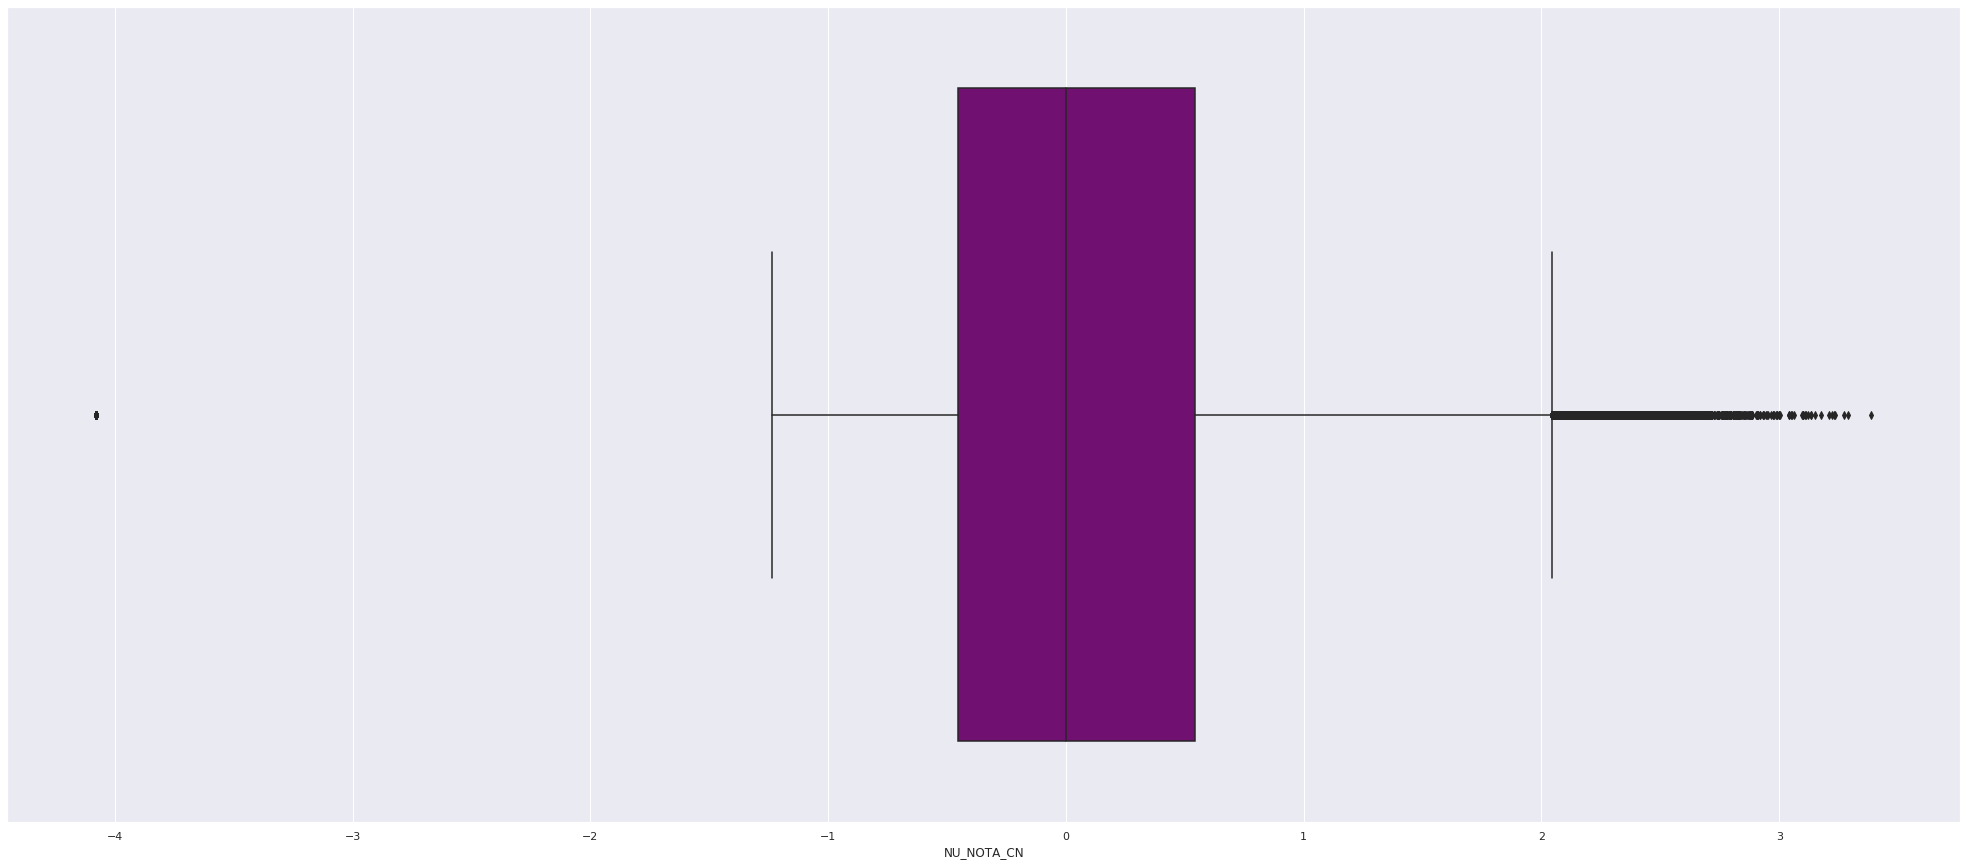

In [30]:
sns.boxplot( df5['NU_NOTA_CN'], color='purple' );

### 5.3. Transformation

#### 5.3.1. Enconding
    - state_holiday - One Hot Enconding
    - store_type - Label enconding
    - assortment - Ordinal Encoding

In [62]:
df5.head(2)

,NU_INSCRICAO,NO_MUNICIPIO_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,NO_MUNICIPIO_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_TEMPO_ADICIONAL,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,d7e73c5f-2db8-4089-9bee-d3a0e045f87f,Ariquemes,31.0,F,0,1,1,1,10,1,1.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100023,Ariquemes,11,RO,1,1,1,1,-0.379879,-0.195122,0.662218,0.421410,1,1.0,680.0,B,A,A,A,2,E,A,B,C,C,C,B,B,B,B,B,A,A,B,A,A,C,A,B,B
1,668bf6e4-ddf7-4810-b31e-7d325e36de4d,Belo Horizonte,23.0,F,1,3,1,1,3,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3106200,Belo Horizonte,31,MG,1,1,1,1,-0.063313,-0.490328,0.569540,0.413191,0,1.0,520.0,B,C,D,B,2,E,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,C,A,B,B


In [49]:
# Using One Hot Enconding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [60]:

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

In [61]:
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3} 
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [62]:
df5.head(25)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,NaN,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,NaN,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,NaN,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,NaN,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,NaN,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
5,6,5,2015-07-31,8.639765,1,1,0,NaN,-0.325806,12,2013,0,31,2015,0,1.0,7,31,31,2015-30,2013-12-01,0.054054,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
6,7,5,2015-07-31,9.638545,1,1,0,NaN,3.495161,4,2013,0,31,2015,0,1.0,7,31,31,2015-30,2013-04-01,0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
7,8,5,2015-07-31,9.046998,1,1,0,NaN,0.837097,10,2014,0,31,2015,0,1.0,7,31,31,2015-30,2014-10-01,-0.081081,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
8,9,5,2015-07-31,9.055556,1,1,0,NaN,-0.048387,8,2000,0,31,2015,0,1.0,7,31,31,2015-30,2000-08-01,2.243243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
9,10,5,2015-07-31,8.879890,1,1,0,NaN,0.133871,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


#### 5.3.2. Response Variable Transformation

In [63]:
df5['sales'] = np.log1p( df5['sales'] )

In [64]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,2.258492,1,1,2,NaN,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,2.273186,1,1,0,NaN,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,2.305163,1,1,0,NaN,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,2.355797,1,1,2,NaN,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,2.249306,1,1,0,NaN,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


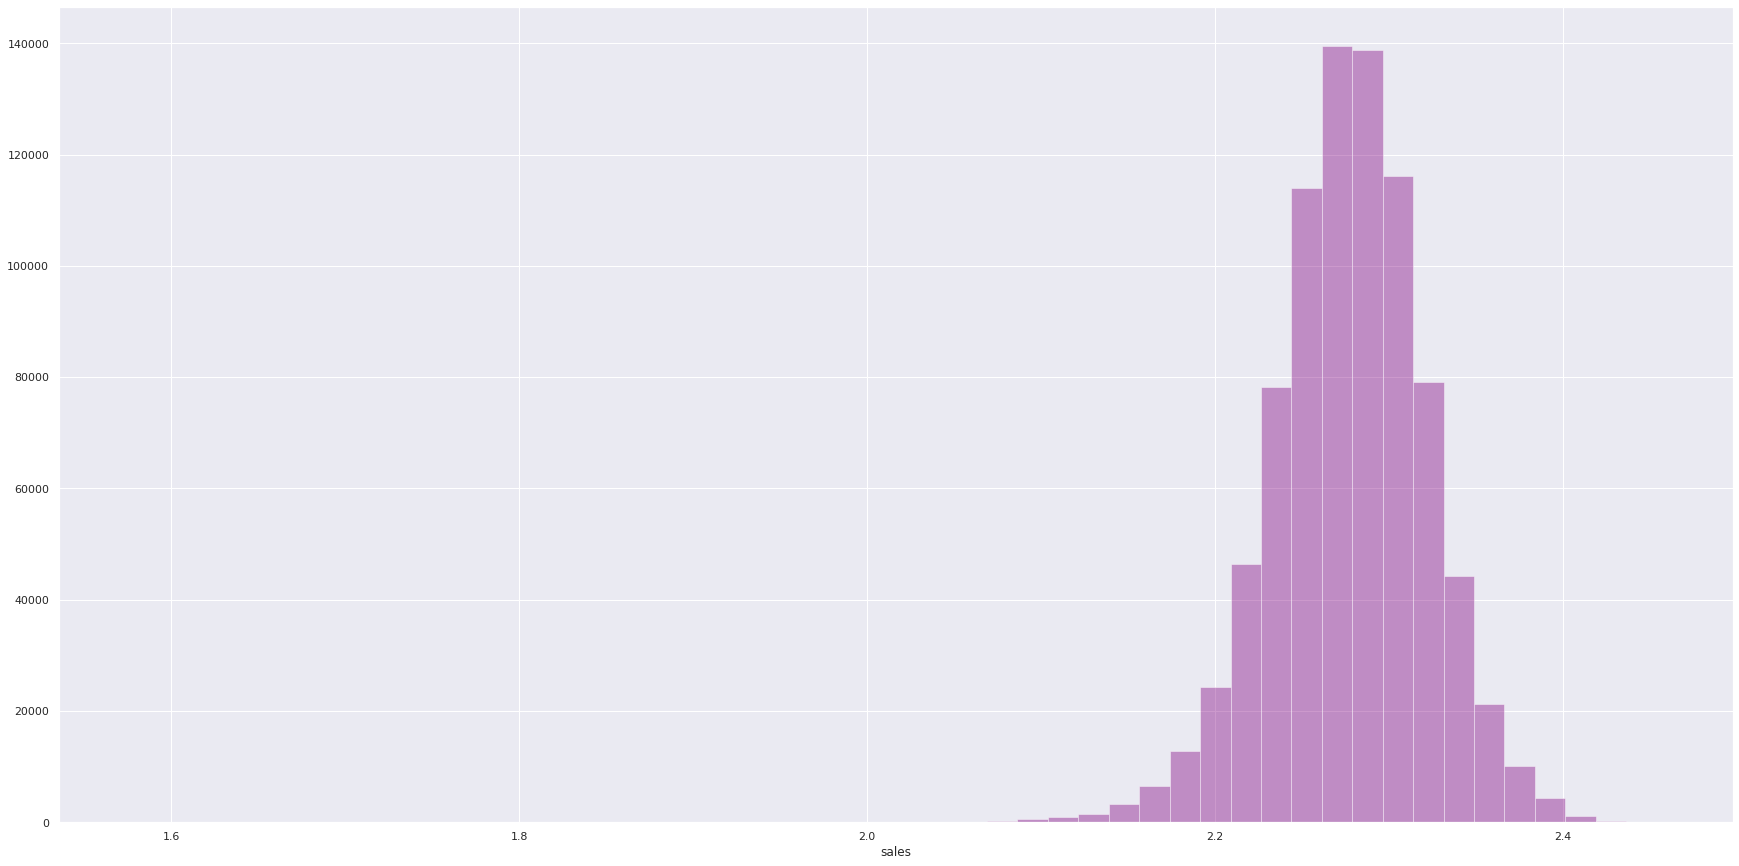

In [65]:
sns.distplot( df5['sales'], kde=False, color='purple'); 

#### 5.3.3. Nature Transformation → Ciclical Transformation

In [66]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7 ))) 
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7 )))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12 ))) 
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12 )))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30 ))) 
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30 )))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52 ))) 
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52 )))

In [101]:
# New DataFrame
df3.to_csv('../data/processed/df_train_clean.csv')

# 6.0. Step 06 -  FEATURE SELECTION

In [4]:
# New Data Frame
df_transf = pd.read_csv('../data/processed/df_train_clean.csv')
#df_transf.head()

In [5]:
df6 = df_transf.copy()

### 6.1. Slpit DataFrame into training dataset

In [6]:
# Occan's Razor Principle → Eliminating Collinear Variables
# whenever we have variables that have equal or collinear values we can eliminate
# and thus have a leaner dataset optimizing our learning model.
cols_drop = ['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA']
df6 = df6.drop( cols_drop, axis=1 )

In [8]:
# training dataset
#X_train = df6[df6['date'] < '2015-06-19']
#y_train = X_train['sales']

# Creating a training set for
#modeling and validation set to check model performance

# eliminando apenas os dados a serem previstos
X = df6.drop(['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT', 'NU_NOTA_REDACAO'], axis=1)
#Selecionando os dados de validação 
y = df6[['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT', 'NU_NOTA_REDACAO']]

# separando o conjunto de treino e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=7)

# indices categoricas
cat = df6.select_dtypes( exclude=['int64', 'float64'] )




### 6.2. Boruta as Feature Selector
Don't run again!

In [84]:
#from boruta import BorutaPy
#from sklearn.ensemble import RandomForestRegressor

In [85]:
#from boruta import BorutaPy
#from sklearn.ensemble import RandomForestRegressor

In [86]:
#BorutaPy( rf, n_estimators=10, verbose=2, random_state=42 ) # → definição do Boruta


#### define training and test for Boruta (generating features with boruta)
# X_train_n = X_train.drop(['date','sales'], axis=1 ).values #define the variable and eliminate unwanted variables for this workout 
# y_train_n = y_train.values.ravel() #Using ravel to put all this into a vector 

#define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=3 ) #define the use of all colors of the machine and do it in parallel and work faster 

# → Running the training with the method  .fit() = it is necessary to inform a vector of numbers (numpy → x_train_n..)
# boruta = BorutaPy( rf, n_estimators=10, verbose=2, random_state=42 ).fit(X_train_n, y_train_n ) 


#### 6.2.1. Best Features from Boruta


In [87]:
# Displays the rank of variables based on a range of values showing which are the best and which are the least interesting for our answer
# cols_selected = boruta.support_.tolist() # → creating a list of the best columns in the set

# Best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1 ) #→ necessary to create a new feature to select within cols_boruta the columns found by the model
# cols_selected_boruta = X_train_fs.iloc[: , cols_selected].columns.to_list() #→ boruta returns a dataframe so it transforms into list

# Comparing selected and unselected columns
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [88]:
# Call Boruta result.
#boruta
# cols_selected_boruta

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=None,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=73, n_jobs=-1,
                                         oob_score=False,
                                         random_state=RandomState(MT19937) at 0x7F2D0B3B0E20,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
         random_state=RandomState(MT19937) at 0x7F2D0B3B0E20, two_step=True,
         verbose=2)

### 6.3. Manual Feature Selection

In [89]:
# cols_selected_boruta #→ return collumns boruta selected

In [13]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [14]:
# columns to add - adding manually dropped variables to the end of the list.
feat_to_add = ['date', 'sales']

# week_of_year_sin and month_sin were manually assigned because they had relevance in our EDA
# during the validation of hypotheses. comparing to ussa tabela e a tabela do boruta realizamos o merge
# and we force learning with our manual analysis

In [15]:
# final features (features droped + cols_selected_boruta + EDA)
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# command to add manual list to end of first list

# 7.0. Step 07 - MACHINE LEARNING MODELLING → test and choose the best model for our analysis

In [ ]:
# Aplicação do CatBoost

model = CatBoostRegressor(iterations=10,
                          depth=3,
                          learning_rate=0.1,
                          loss_function='RMSE')

# treino e teste
model.fit(X_train, y_train,
          #Variaveis
          cat_features=cat,
          #Eval_set = dados de teste (validação) e plot resultado
          eval_set=(X_test, y_test), plot=True)

In [ ]:
print(model.get_best_iteration())

In [ ]:
# Plot do Output para analise da predição

df_pred = pd.DataFrame()

df_pred['ID'] = test['ID']
df_pred['NU_NOTA_CN'] = test['NU_NOTA_CN']
df_pred['NU_NOTA_CH'] = test['NU_NOTA_CH']
df_pred['NU_NOTA_LC'] = test['NU_NOTA_LC']
df_pred['NU_NOTA_MT'] = test['NU_NOTA_MT']
df_pred['NU_NOTA_REDACAO'] = test['NU_NOTA_REDACAO']

df_test

In [19]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

In [21]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales
41396,1,1,2,NaN,-0.170968,9,2008,0,25,2015,0.891892,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,2.245354
41397,2,1,0,NaN,-0.283871,11,2007,1,13,2010,1.027027,0.908884,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,2.256303
41398,3,1,0,NaN,1.903226,12,2006,1,14,2011,1.189189,0.788155,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,2.295330
41399,4,1,2,NaN,-0.275806,9,2009,0,25,2015,0.729730,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,2.311710
41400,5,1,0,NaN,4.448387,4,2015,0,25,2015,-0.189189,0.287016,-0.433884,-0.900969,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,2015-06-18,2.251511


In [26]:
# generating the mean_absolute_error function because we haven't implemented it in numpy yet
def mean_absolute_percentage_error(y, yhat): # receives actual value for predicted
    return np.mean( np.abs(( y - yhat ) / y )) # abs function turns negative to positive

# Function implementation ML_ERROR
def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

## 7.1. Average Model → in the comparison between the models, this one behaved better

In [18]:
# avg model → average sales per store
aux1 = x_test.copy()
aux1['sales'] = y_test.copy() 

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'}) 
aux1 = pd.merge( aux1, aux2, how='left', on='store') 
yhat_baseline = aux1['predictions'] 

# Performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline )) 
baseline_result 

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [102]:
#from sklearn.linear_model import LinearRegression, Lasso

In [19]:
# model
lr = LinearRegression().fit( x_train, y_train ) 

# prediction
yhat_lr = lr.predict( x_test )

# performance 
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

 - The real value

In [20]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularied Model - Lasso

In [21]:
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance 
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1889.425058,0.294563,2720.392711


### 7.3.1 Linear Regression Regularied Model - Lasso

In [22]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2113.57 +/- 343.78,0.29 +/- 0.01,3048.94 +/- 509.59


## 7.4. Random Forest Regressor

In [24]:
#from sklearn.ensemble import RandomForestRegressor

In [23]:
# model
rf = RandomForestRegressor( n_estimators=60, n_jobs=3, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.022205,0.100616,1016.939986


### 7.4.1.  Random Forest Regressor - Cross Validation


In [24]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv
# Model Name	MAE CV	MAPE CV	RMSE CV
# 0	Random Forest Regressor	839.53 +/- 216.46	0.12 +/- 0.02	1259.02 +/- 316.7


KFold number: 5

KFold number: 4

KFold number: 3

KFold number: 2

KFold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.53 +/- 216.46,0.12 +/- 0.02,1259.02 +/- 316.7


## 7.5. XGBoost Regressor

In [83]:
#import xgboost as xgb

In [25]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,851.278592,0.123671,1265.695962


In [26]:
with open('../model/xgb_result.pkl', 'wb') as f:
    pickle.dump(xgb_result, f)

In [27]:
xgb_result = pickle.load(open ('../model/xgb_result.pkl', 'rb'))  

In [28]:
xgb_result
#"""Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	6635.050477	0.941713	7283.881093 → 10 tree"""

#'''Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	2434.527038	0.302996	3245.532275 → 30 tree'''

#'''Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	1011.47553	0.146031	1497.513356 → 70 tree'''

#'''Model Name	MAE	MAPE	RMSE
#0	XGBoost Regressor	851.278592	0.123671	1265.695962 → 100 tree'''

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,851.278592,0.123671,1265.695962


### 7.5.1. XGBoost Regressor - Cross Validation

In [29]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold number: 5

KFold number: 4

KFold number: 3

KFold number: 2

KFold number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1017.94 +/- 170.79,0.14 +/- 0.02,1463.65 +/- 234.28


In [18]:
# Model Name	MAE CV	MAPE CV	RMSE CV
# 0	XGBoost Regressor	1017.94 +/- 170.79	0.14 +/- 0.02	1463.65 +/- 234.28

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [51]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )

modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.022205,0.100616,1016.939986
0,XGBoost Regressor,851.278592,0.123671,1265.695962
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression - Lasso,1889.425058,0.294563,2720.392711
0,Linear Regressor,1980.039151,0.283893,2840.000319


In [52]:
"""Completion of this analysis:
The problem we are trying to analyze (Rossmann) is not a simple problem, and for being
so complex we must apply deeper learning models, shown in the results
of the comparison."""

'Completion of this analysis:\nThe problem we are trying to analyze (Rossmann) is not a simple problem, and for being\nso complex we must apply deeper learning models, shown in the results\nof the comparison.'

### 7.6.2. Real Performance - Cross Validation

In [53]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2113.57 +/- 343.78,0.29 +/- 0.01,3048.94 +/- 509.59
0,Random Forest Regressor,839.53 +/- 216.46,0.12 +/- 0.02,1259.02 +/- 316.7
0,XGBoost Regressor,1017.94 +/- 170.79,0.14 +/- 0.02,1463.65 +/- 234.28


#### Save the Model of machine Learning

In [62]:
with open('../model/sale_xgboost.pkl', 'wb') as f:
    pickle.dump(modelling_result_cv, f)
    
    

In [63]:
arq = open('../model/sale_xgboost.pkl', 'rb') 
   
x = pickle.load(arq)

In [64]:
x

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2113.57 +/- 343.78,0.29 +/- 0.01,3048.94 +/- 509.59
0,Random Forest Regressor,839.53 +/- 216.46,0.12 +/- 0.02,1259.02 +/- 316.7
0,XGBoost Regressor,1017.94 +/- 170.79,0.14 +/- 0.02,1463.65 +/- 234.28


# 8.0. Step 08 - Hipyer Parameter Fine Tuning

In [4]:
import random
import warnings

warnings.filterwarnings( 'ignore' )

## 8.1. Random Search
    

In [21]:
param = {'n_estimators': [100, 350, 500, 800, 950], 
         'eta': [0.01, 0.03], 
         'max_depth': [3, 5, 9], 
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytee': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15] }

MAX_EVAL = 5 

### Run only in case of feature changes

In [27]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL):
    # Choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp) 
    
    # model XgBoost
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytee'],
                                  min_child_weight=hp['min_child_weight'] ) 

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False ) 
        
    final_result = pd.concat([final_result, result])

final_result   

{'n_estimators': 950, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'n_estimators': 800, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 950, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 3}
{'n_estimators': 350, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1242.35 +/- 129.62,0.17 +/- 0.01,1780.52 +/- 163.42
0,XGBoost Regressor,967.59 +/- 144.25,0.14 +/- 0.02,1377.06 +/- 194.23
0,XGBoost Regressor,874.79 +/- 127.54,0.12 +/- 0.01,1247.21 +/- 180.74
0,XGBoost Regressor,1454.64 +/- 156.6,0.2 +/- 0.01,2092.43 +/- 190.82
0,XGBoost Regressor,876.82 +/- 139.17,0.12 +/- 0.01,1251.63 +/- 193.45


In [48]:
#final_result
# Here, choose the one with the best result on the RMSE CV (lowest result)
#or the one whose parameters are smaller but the errors are very close

"""
1 - {'n_estimators': 800, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 3}
2   {'n_estimators': 950, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.3, 'min_child_weight': 15}
3   {'n_estimators': 500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 8}
4   {'n_estimators': 800, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 8} → escolhi este pela proximidade de valores ao melhor estimador
5 - {'n_estimators': 950, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.7, 'min_child_weight': 8}"""


'''{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytee': 0.9, 'min_child_weight': 15}
{'n_estimators': 800, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytee': 0.3, 'min_child_weight': 15}
{'n_estimators': 800, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}  → escolhido pelo modelo
{'n_estimators': 100, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 8}
{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 15}
Model Name	MAE CV	MAPE CV	RMSE CV
0	XGBoost Regressor	1527.56 +/- 109.89	0.21 +/- 0.0	2227.36 +/- 177.93
0	XGBoost Regressor	1231.43 +/- 97.16	0.17 +/- 0.0	1789.61 +/- 151.99
0	XGBoost Regressor	776.66 +/- 121.34	0.11 +/- 0.01	1126.29 +/- 187.18
0	XGBoost Regressor	1785.22 +/- 123.03	0.25 +/- 0.0	2579.52 +/- 189.79
0	XGBoost Regressor	1542.55 +/- 103.1	0.22 +/- 0.0	2245.35 +/- 158.46'''

"""Teste dia 23/12
{'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}
{'n_estimators': 950, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}
→ {'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}
{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 3}

|Model Name	|MAE CV	|MAPE CV	|RMSE CV|
|======*|======*|======*|======*|
1	XGBoost Regressor	1397.64 +/- 110.28	0.2 +/- 0.0	2040.59 +/- 164.63
2	XGBoost Regressor	1398.91 +/- 109.5	0.2 +/- 0.0	2043.59 +/- 162.17
3	XGBoost Regressor	862.99 +/- 99.94	0.12 +/- 0.01	1235.09 +/- 148.75
4	XGBoost Regressor	814.49 +/- 119.37	0.11 +/- 0.01	1171.58 +/- 179.18
5	XGBoost Regressor	1539.8 +/- 108.17	0.22 +/- 0.0	2248.29 +/- 167.92"""

"Teste dia 23/12\n{'n_estimators': 500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}\n{'n_estimators': 500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 8}\n{'n_estimators': 950, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.9, 'min_child_weight': 3}\n→ {'n_estimators': 500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytee': 0.7, 'min_child_weight': 15}\n{'n_estimators': 100, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytee': 0.7, 'min_child_weight': 3}\n\n|Model Name\t|MAE CV\t|MAPE CV\t|RMSE CV|\n|======*|======*|======*|======*|\n1\tXGBoost Regressor\t1397.64 +/- 110.28\t0.2 +/- 0.0\t2040.59 +/- 164.63\n2\tXGBoost Regressor\t1398.91 +/- 109.5\t0.2 +/- 0.0\t2043.59 +/- 162.17\n3\tXGBoost Regressor\t862.99 +/- 99.94\t0.12 +/- 0.01\t1235.09 +/- 148.75\n4\tXGBoost Regressor\t814.49 +/- 119.37\t0.11 +/- 0.01\t1171.58 +/- 179.18\n5\tXGBoost Reg

## 8.2. Final Model
    

In [28]:
param_tuned = {'n_estimators': 350, 
               'eta': 0.01, 
               'max_depth': 9, 
               'subsample': 0.1, 
               'colsample_bytee': 0.9, 
               'min_child_weight': 3}

MAX_EVAL = 3 

In [29]:
# model XgBoost
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytee'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, y_train) 

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) ) 
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,688.833353,0.101738,994.372393


In [30]:
#pickle.dump(model_xgb_tuned ('/home/bruno/repos/Rossmann_Sales_Prediction_bmg/model/model_rossmann.pkl', 'wb'))

# save the final model
with open('../model/model_rossmann.pkl', 'wb') as file:
    pickle.dump(xgb_result_tuned, file)

In [31]:
model_xgb_tuned_final = pickle.load(open ('/home/bruno/repos/Rossmann_Sales_Prediction_bmg/model/model_rossmann.pkl', 'rb'))
#model_xgb_tuned_final

In [32]:

yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

## performance
xgb_result_tuned_final = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) ) 
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,688.833353,0.101738,994.372393


### Calculating the MEP

mpe = mean_percentage_error( np.expm1( y_test), np.expm1(yhat_xgb_tuned) )
mpe

# 9.0. Step 09 - Error Translation and Interpretation


In [33]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [34]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum(). reset_index()

# MAE and MAPE → report error translate
#Mean Absolute Error
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAE'})
#Mean Absolute Percentage Error
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store') 
df92 = pd.merge(df91, df9_aux3, how='inner', on='store') 


In [35]:
# The best and worst scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [36]:
df92.head(3)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162411.859375,162117.454887,162706.263863,294.404488,0.065719
1,2,177249.046875,176871.994998,177626.098752,377.051877,0.079791
2,3,261931.453125,261354.514807,262508.391443,576.938318,0.080235


In [37]:
df92.head(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162411.859375,162117.454887,162706.263863,294.404488,0.065719
1,2,177249.046875,176871.994998,177626.098752,377.051877,0.079791
2,3,261931.453125,261354.514807,262508.391443,576.938318,0.080235
3,4,345611.468750,344727.237344,346495.700156,884.231406,0.084374


In [38]:
# How to show the business team which stores are more challenging in the prediction?

df92.sort_values('MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107721.984375,104267.235531,111176.733219,3454.748844,0.607736
908,909,228006.625000,220072.920814,235940.329186,7933.704186,0.527464
285,286,169510.140625,168609.332447,170410.948803,900.808178,0.322231
594,595,358482.000000,353867.648860,363096.351140,4614.351140,0.315539
875,876,192926.015625,188991.725437,196860.305813,3934.290188,0.290832


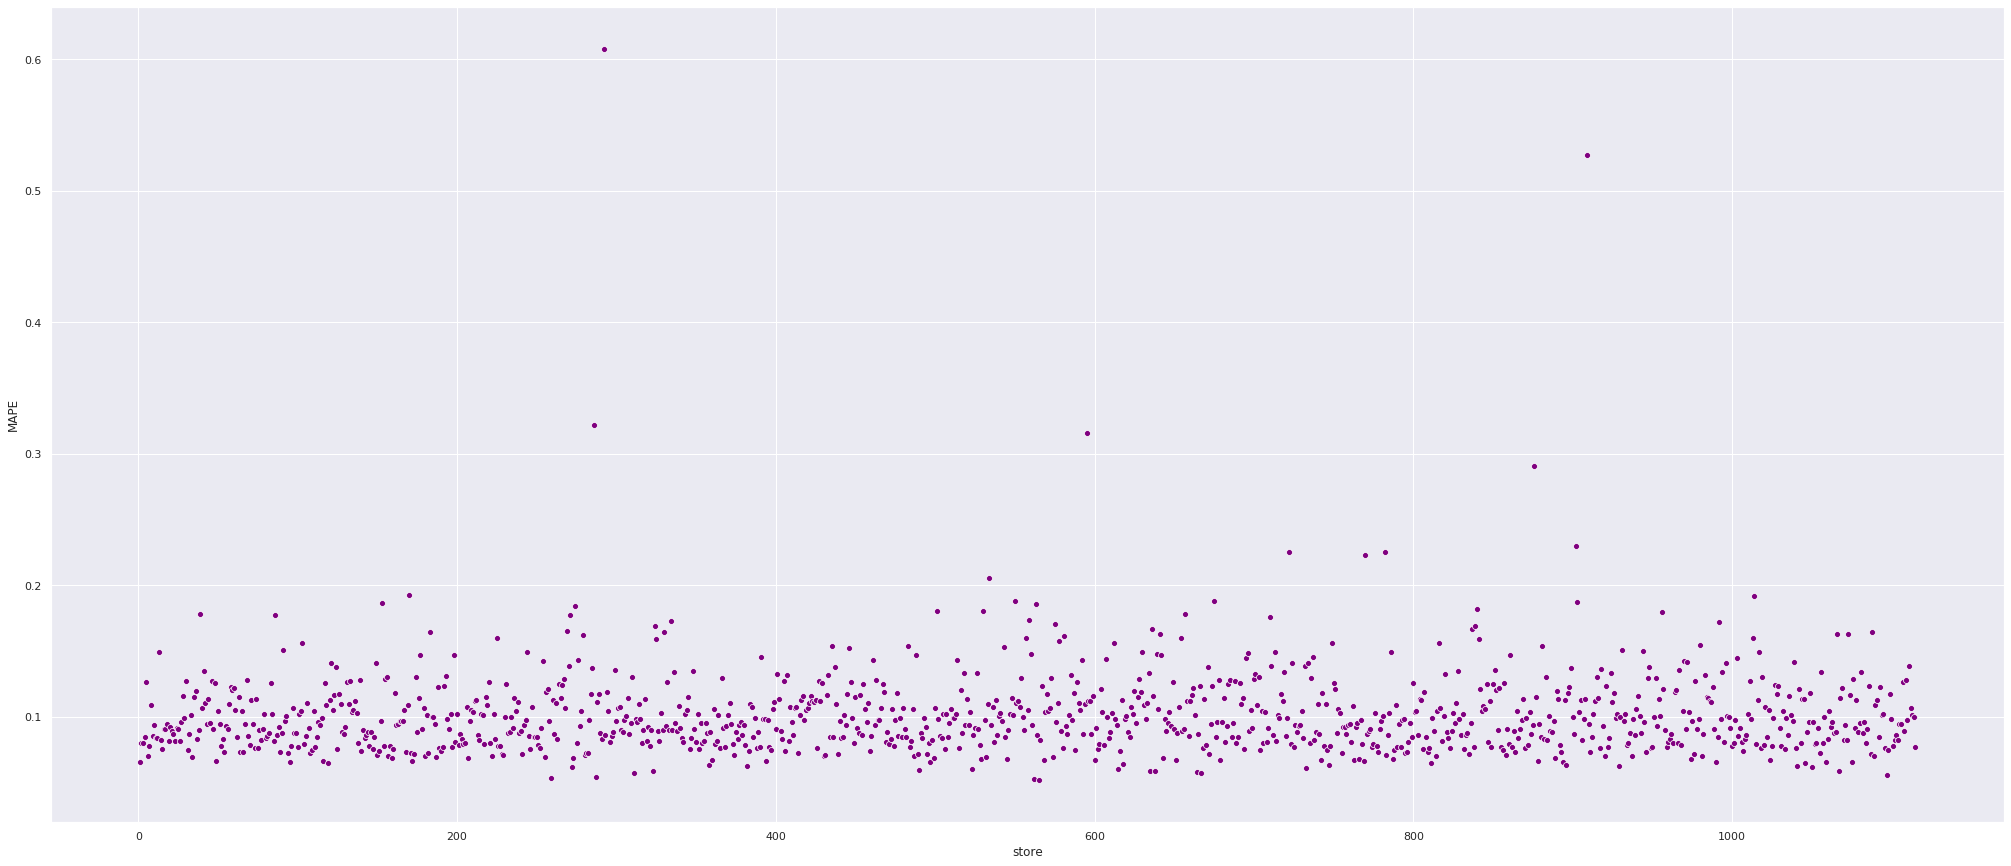

In [39]:
sns.scatterplot(x='store', y='MAPE', data=df92, color="purple" );

## 9.2 Total Performance

In [40]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('€{:,.2f}'.format)
df93.head()

,Scenario,Values
0,predictions,"€286,381,809.29"
1,worst_scenario,"€285,609,778.34"
2,best_scenario,"€287,153,840.24"


## 9.3 Machine Learning Performance

In [41]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


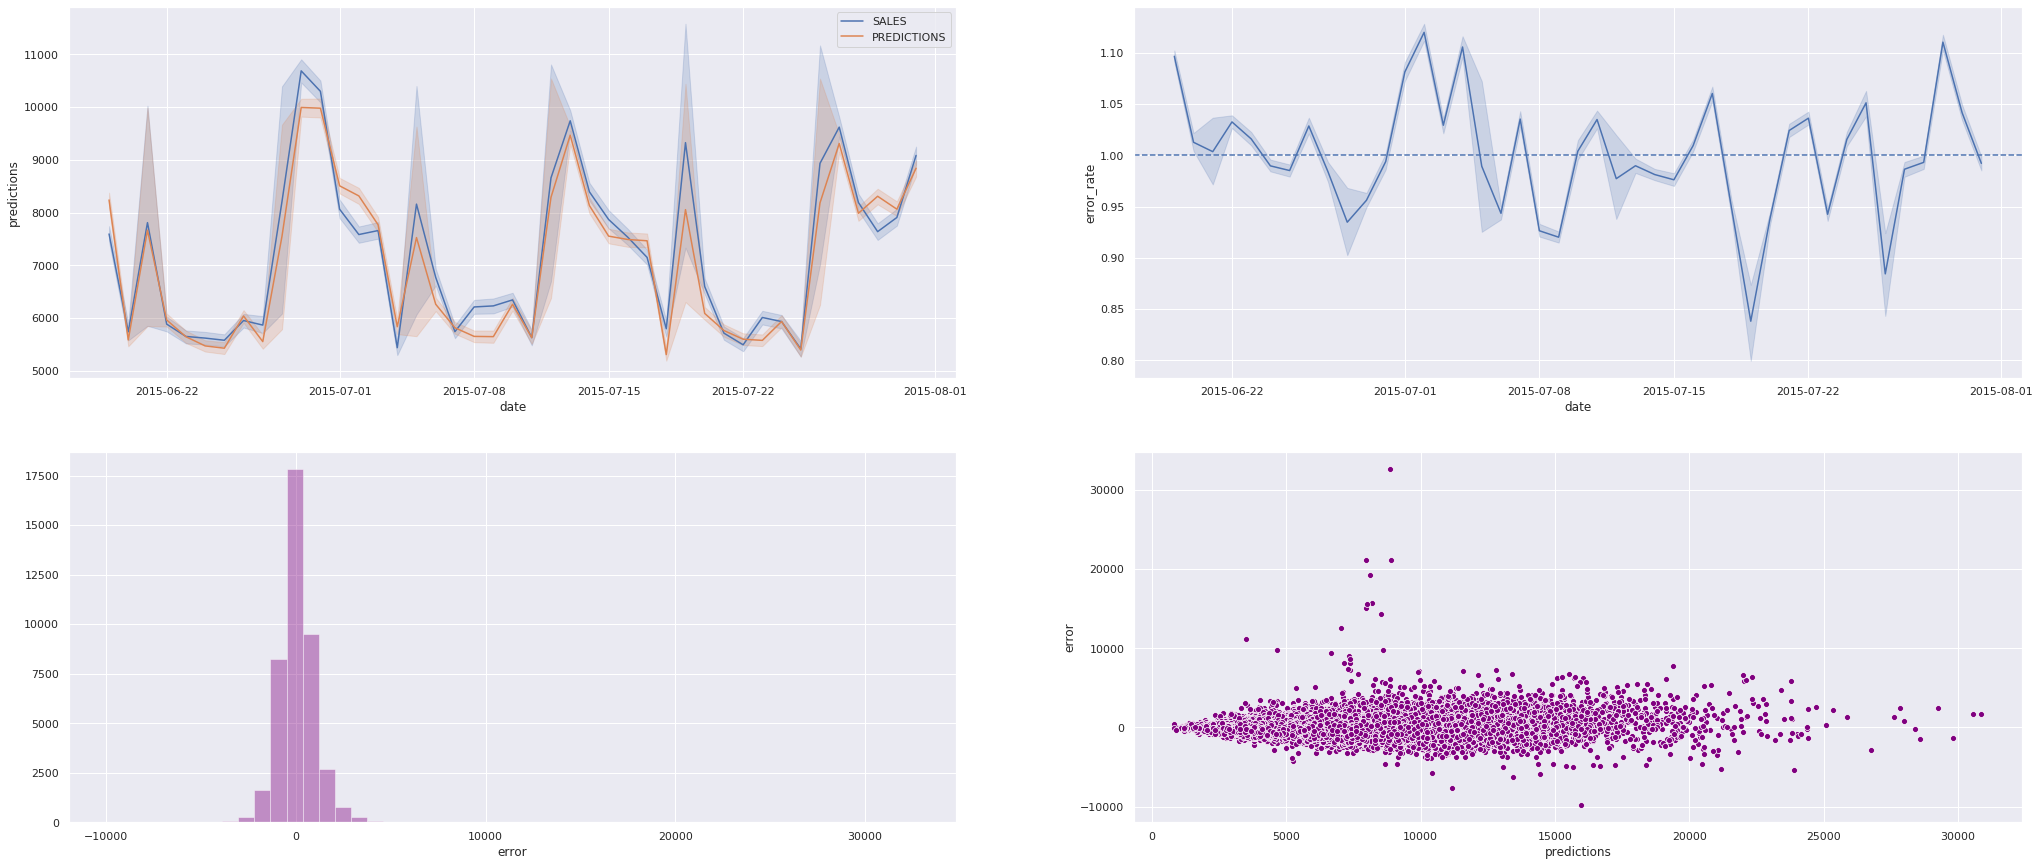

In [42]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');


plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--'); 

plt.subplot(2, 2, 3)
sns.distplot(df9['error'], kde=False, color='purple');

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'], color='purple');

# 10.0. Step 10 - Deploy Model to Production


In [ ]:
# Save the final model
#pickle.dump(model_xgb_tuned ('/home/bruno/repos/Rossmann_Sales_Prediction_bmg/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [22]:
import math
import pickle
import datetime
import inflection

import numpy  as np
import pandas as pd


class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/bruno/repos/Rossmann_Sales_Prediction_bmg/' 
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    def data_cleaning(self, df1):
        
        # Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list(map(snakecase, cols_old))
        
        #rename
        df1.columns = cols_new


        # Data Types

        df1['date'] = pd.to_datetime( df1['date'])

        # Fillout "NA" 
        #competition_distance - Understand what the "NA's" in this column mean (read in the business issue description)
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        #Possible dataset filling errors
        #Strategy. Use the month of sale as a reference when replacing the NA value using CRISP
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        #Same reasoning as above
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

        #promo2_since_week  
        #Describe the calendar year and week when the store started participating in promo 2
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

        #promo_interval
        #Describes the breaks for the promotion and when it started
        #Here we will make two changes. 1st Create a list | 2nd Filter if the month of sale is within the list and show number 1.

        # 1º - Dictionary with the months
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        # Activate the column and replace the NA by 0, without returning a value and already modifying the line.
        df1['promo_interval'].fillna(0, inplace=True)

        # Creating a new column transforming the constant date in the row into month
        # and replace the numeric value with the corresponding dictionary created above
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        # 2º Filter if the month of sale is in the list and show the number 1 and 0 if not.
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

        # Change Data Types
        
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1

    def feature_engineering(self, df2):
        
        #Feature Engineering

        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear 

        #year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

        #competition since 
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                           month=x['competition_open_since_month'],
                                                                           day=1), axis=1 )
        
        #competition time month
        df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype( int )

        #promo since 
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x:datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
        
        #promo time week
        df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # FILTERING VARIABLE
        
        # Filtering Rows
        df2 = df2[(df2['open'] != 0)]

        # Filtering columns
        cols_drop = ['open',  'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop,axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):
        # Rescaling
        
        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo_time_week 
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fransform( df5[['year']].values )
    

        # Transformation
        #Enconding
        
        #state_holiday - using One Hot Enconding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        #store_type - Label enconding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
         
        #assortment
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3} 
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        # Nature Transformation → Ciclical Transformation

        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7 )))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7 )))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12 )))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12 )))
        
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30 )))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30 )))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52 )))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52 )))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                         'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month',
                         'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                         'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]

    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [23]:
import os
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open('../model/model_rossmann.pkl', 'rb') )

# Initializing API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # Data cleaning
        df1 = pipeline.data_cleaning( test_raw )
                
        # Feture engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # Data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # Prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
    else:
        
        return Response( '{}', status=200, mimetype='application/json') #reader to request

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [5]:
import json
import requests
import pandas as pd

df_store_raw = pd.read_csv('../dataset/store.csv', low_memory=False)
df10 = pd.read_csv( '../dataset/test.csv' )

In [6]:
df_store_raw.head(100)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


In [7]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([22, 2, 3, 50, 40, 100])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [8]:
# Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records') )

In [9]:
data

'[{"Store": 3, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 14130.0, "CompetitionOpenSinceMonth": 12.0, "CompetitionOpenSinceYear": 2006.0, "Promo2": 1, "Promo2SinceWeek": 14.0, "Promo2SinceYear": 2011.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 40, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 180.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 

In [10]:
# API Call
url = 'rossmann-app-bmg.herokuapp.com/rossmann/predict'

header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header) #→ original code
print( 'Status Code {}'.format( r.status_code ) )


MissingSchema: Invalid URL 'rossmann-app-bmg.herokuapp.com/rossmann/predict': No schema supplied. Perhaps you meant http://rossmann-app-bmg.herokuapp.com/rossmann/predict?

In [30]:
# return to dataframe
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range( len( d2 ) ):
    print('Store Number {} will sell €{:,.2f} in the next six weeks'. format(
           d2.loc[i, 'store'],
           d2.loc[i, 'prediction'] ) )

Store Number 3 will sell €197,775.80 in the next six weeks
Store Number 22 will sell €173,477.56 in the next six weeks
Store Number 40 will sell €184,330.40 in the next six weeks
Store Number 50 will sell €206,946.04 in the next six weeks
Store Number 100 will sell €262,622.72 in the next six weeks
